In [1]:
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from skbio.stats.composition import clr
from sklearn.metrics import balanced_accuracy_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from helper import tool_text_styling_dict, tool_palette

plt.style.use("./paper.mplstyle")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

md = pd.read_table("../data/tcga/processed/processed_md.2.tsv", sep="\t", index_col=0)
md["investigation"] = md["investigation"].str.replace("TCGA-", "")
print(md.shape)
invest_labels = pd.Series(
    LabelEncoder().fit_transform(md["investigation"]),
    index=md.index
)
center_labels = pd.Series(
    LabelEncoder().fit_transform(md["data_submitting_center_label"]),
    index=md.index
)

(1124, 41)


In [3]:
investigations = [x for x in md["investigation"].value_counts().index if x != "BRCA"]
len(investigations)

18

In [4]:
tbl = biom.load_table("../data/tcga/processed/species/processed_tbl.bacteria.2.biom")

In [5]:
tbl.shape

(2302, 1124)

In [6]:
centers = md["data_submitting_center_label"].unique()

center_pal = dict(zip(
    centers,
    sns.color_palette("colorblind", len(centers))
))

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/m

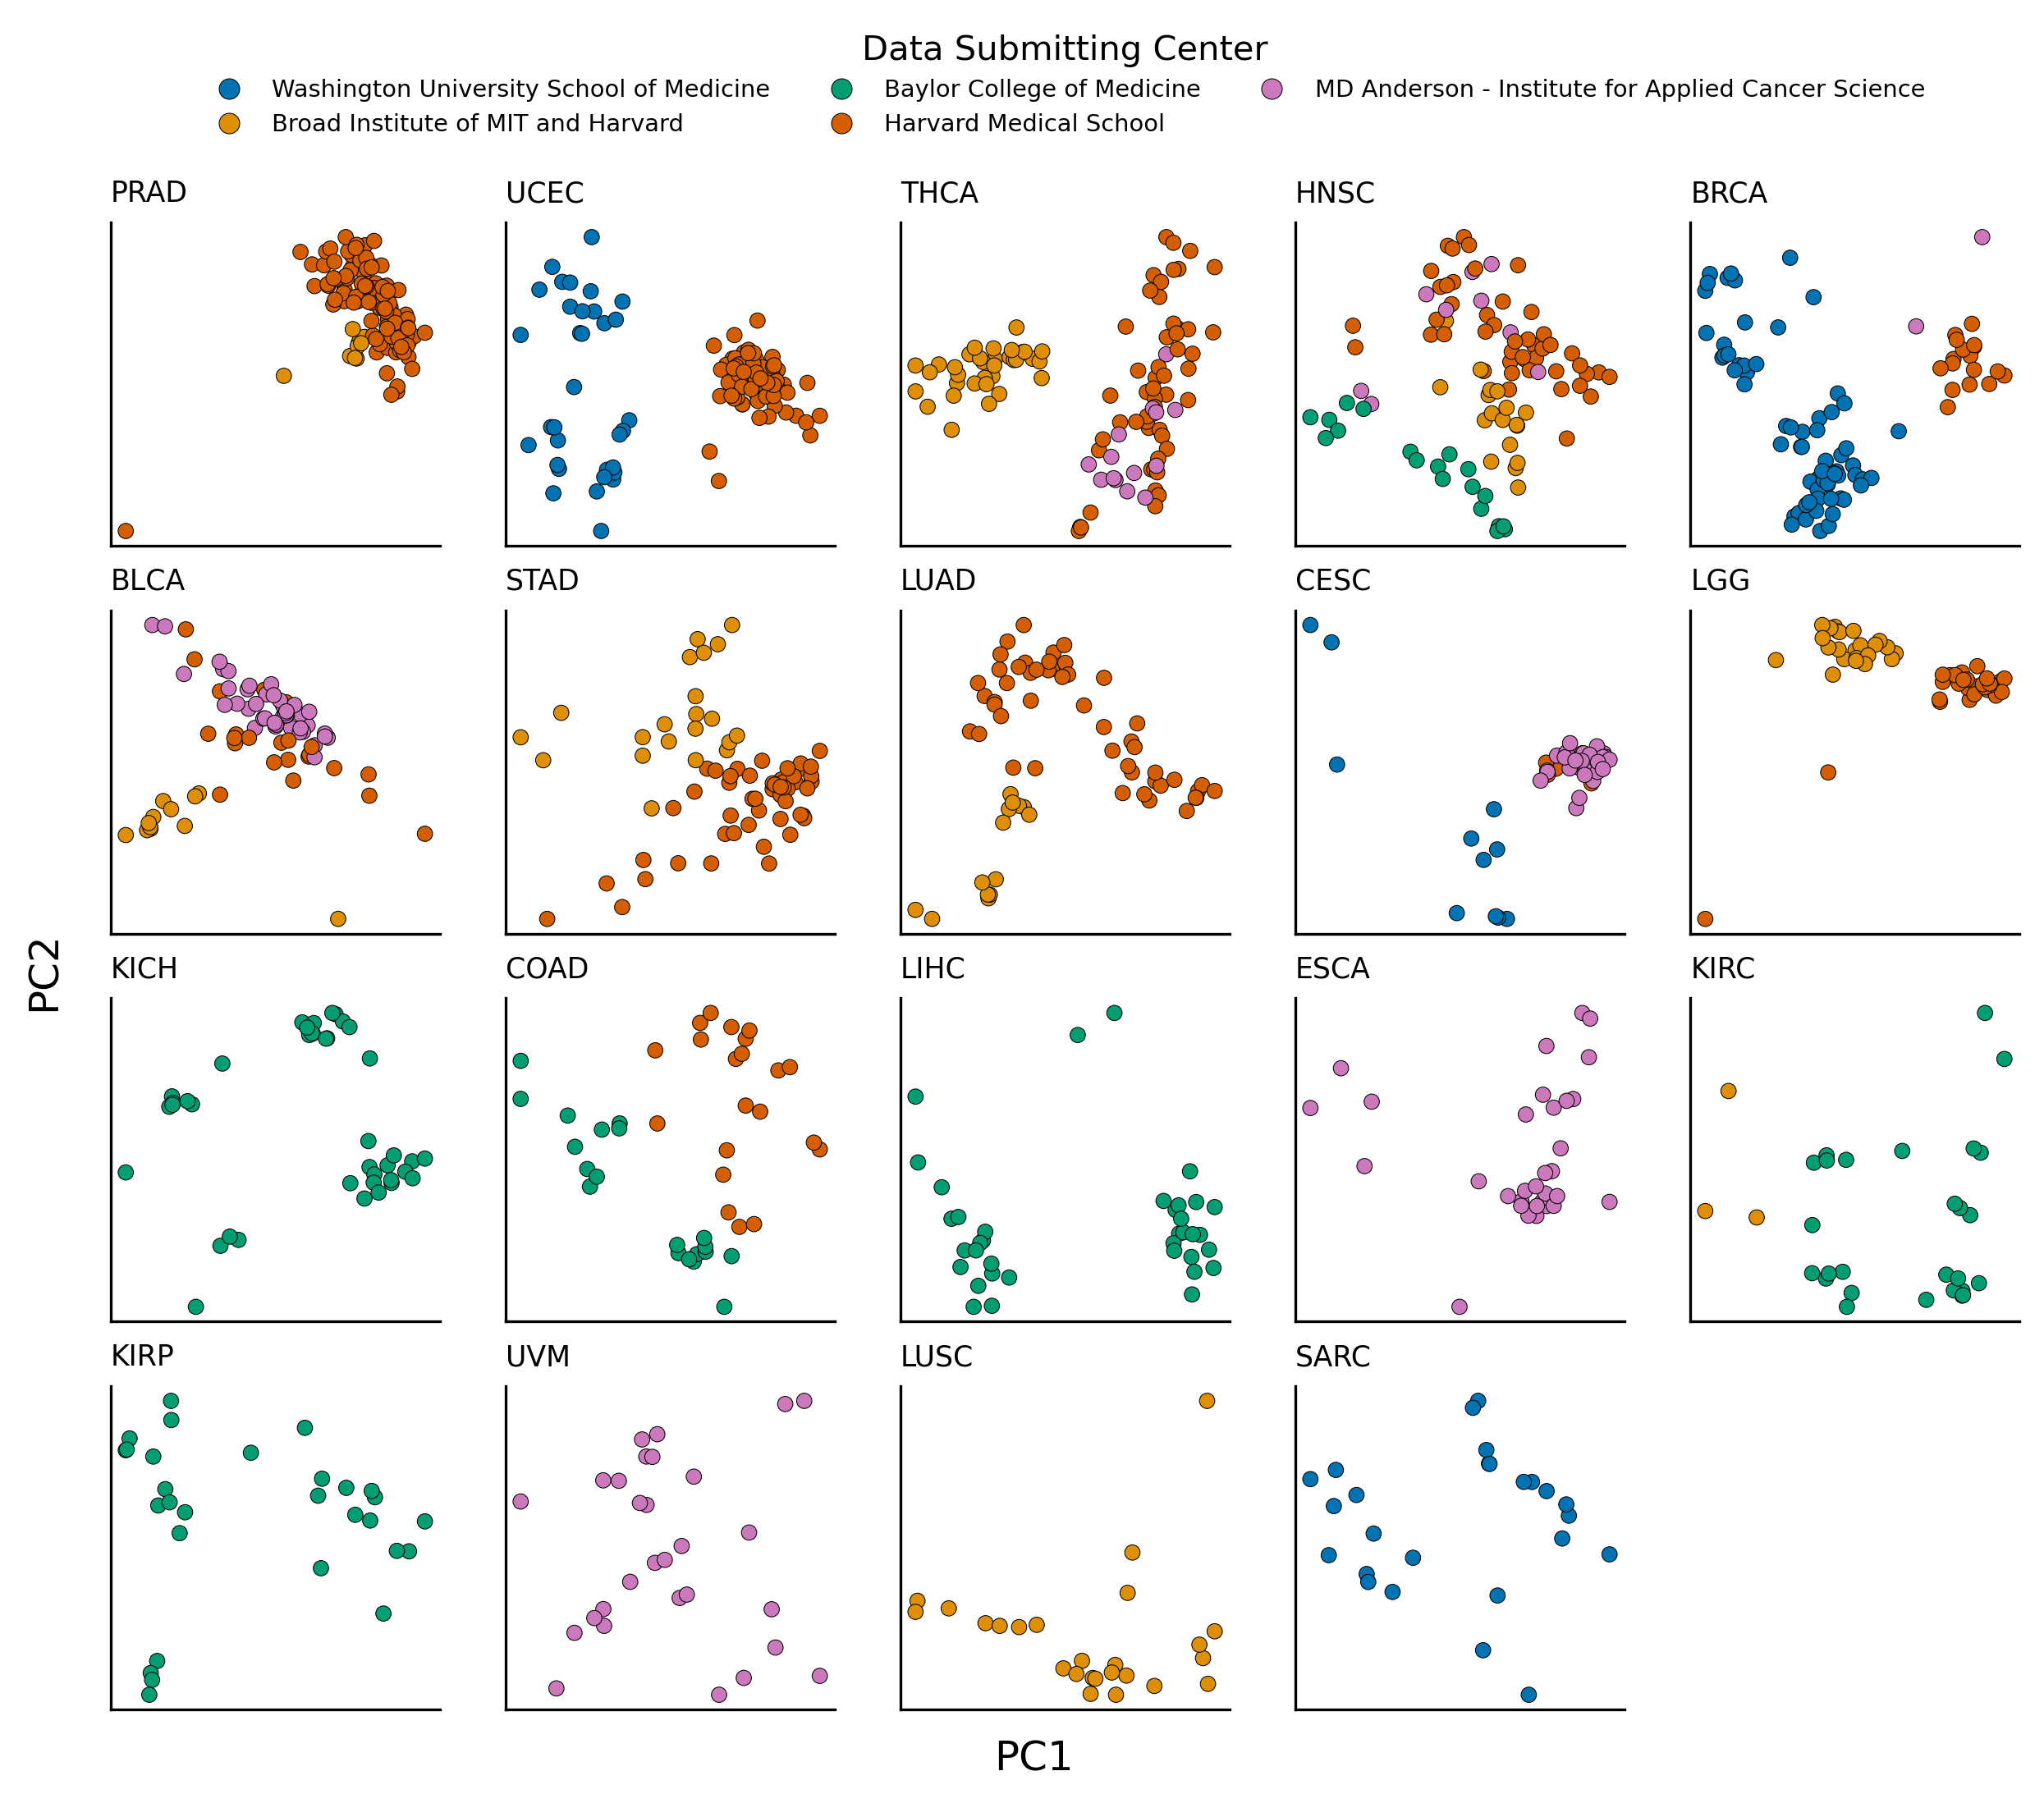

In [7]:
from gemelli.rpca import rpca

fig = plt.figure(figsize=(10, 8))
axs = []

for i, invest in enumerate(md["investigation"].value_counts().index, start=1):
    idx = md[md["investigation"] == invest].index
    tbl_filt = tbl.filter(idx, inplace=False)
    tbl_filt.remove_empty()
    
    ord_res, dm = rpca(tbl_filt)
    samp_axes = ord_res.samples.join(md, how="inner")
    
    ax = fig.add_subplot(4, 5, i)
    sns.scatterplot(
        data=samp_axes,
        x="PC1",
        y="PC2",
        hue="data_submitting_center_label",
        palette=center_pal,
        legend=False,
        linewidth=0.25,
        edgecolor="black",
        s=20,
        ax=ax
    )

    ax.set_title(invest, fontsize="small")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    axs.append(ax)
    
from matplotlib.lines import Line2D

handles = []
for center, color in center_pal.items():
    handle = Line2D([0], [0], color=color, label=center, marker="o",
                    lw=0, mew=0.25, mec="black")
    handles.append(handle)
    
axs[2].legend(
    handles=handles,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=[0.5, 1.2],
    frameon=False,
    title="Data Submitting Center"
)

fig.supylabel("PC2", x=0.09)
fig.supxlabel("PC1", y=0.09)
    
plt.savefig("../figures/tcga/cancer_type_rpca.pdf")
plt.show()

In [8]:
import re

invest_reg = re.compile("\[T.TCGA-(\w+)\]_(mean|std)")

In [9]:
def rename_invest_cols(x):
    invest, agg_type = invest_reg.search(x).groups()
    return "_".join([invest, agg_type])

summ_diff_raw = pd.read_table("../results/tcga/species/birdman_results.bacteria.2.tsv", sep="\t", index_col=0)
summ_diff = summ_diff_raw.filter(like="TCGA")
summ_diff = summ_diff.rename(columns=rename_invest_cols)
summ_diff.index = summ_diff.index.astype(str)
summ_diff.head()

,BLCA_mean,CESC_mean,COAD_mean,ESCA_mean,HNSC_mean,KICH_mean,KIRC_mean,KIRP_mean,LGG_mean,LIHC_mean,...,LGG_std,LIHC_std,LUAD_std,LUSC_std,PRAD_std,SARC_std,STAD_std,THCA_std,UCEC_std,UVM_std
Feature,,,,,,,,,,,,,,,,,,,,,
G000143845,-1.076777,0.429463,0.659927,3.286459,5.279673,0.363183,0.901009,1.558132,-2.257828,0.325224,...,3.067291,2.784021,2.946356,3.398437,3.143958,3.400918,2.227340,2.860714,2.944276,3.298936
G009740265,-0.705101,-2.662072,2.803963,1.322989,1.072876,0.919733,1.220398,1.036483,1.572532,1.215891,...,2.463396,2.659075,3.088532,3.508254,3.288815,3.072347,2.290449,3.008559,2.338097,3.375193
G002370355,1.177119,-0.647524,-3.407568,-1.585086,0.703871,-2.347963,0.913753,0.032247,0.644858,1.017276,...,2.563343,2.711329,2.931985,3.339980,3.005388,2.548292,2.177111,2.258369,2.040992,3.524083
G001042675,-3.012375,-0.203799,-3.342081,2.401584,3.227162,0.712793,1.403987,2.457508,-2.183884,0.872609,...,3.276169,2.713204,2.488785,3.349009,3.183500,2.521516,2.289744,2.316043,2.178537,3.526639
G000284255,-0.513025,-2.128528,2.727296,-1.076555,0.599714,0.233945,0.850228,-2.389894,1.337389,-2.727587,...,2.225297,3.261608,2.122095,2.626535,2.434110,3.554600,2.279388,2.023715,2.260910,3.812598


In [10]:
summ_diff.shape

(2302, 36)

In [11]:
summ_diff_cent = summ_diff.filter(like="mean")
summ_diff_cent = summ_diff_cent.apply(lambda x: x - x.mean(), axis=0)
summ_diff_cent = summ_diff_cent.rename(columns=lambda x: x.replace("_mean", ""))
summ_diff_cent.head()

,BLCA,CESC,COAD,ESCA,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,PRAD,SARC,STAD,THCA,UCEC,UVM
Feature,,,,,,,,,,,,,,,,,,
G000143845,-0.244104,1.212297,-0.755431,2.967919,3.888750,0.007588,0.332989,1.237032,-1.802574,0.359519,-1.976791,-1.750772,-1.319163,-1.638461,2.909206,-2.027297,-3.393146,-0.101788
G009740265,0.127573,-1.879238,1.388604,1.004450,-0.318047,0.564138,0.652379,0.715384,2.027786,1.250187,-1.714187,-1.241196,-0.880759,-2.683375,1.870487,-1.946919,-1.694939,-0.553125
G002370355,2.009793,0.135310,-4.822927,-1.903626,-0.687051,-2.703558,0.345734,-0.288853,1.100112,1.051571,-1.757795,-2.362929,-1.235842,2.412882,1.310313,2.299523,2.413938,0.350209
G001042675,-2.179702,0.579035,-4.757440,2.083044,1.836239,0.357198,0.835968,2.136408,-1.728631,0.906905,1.434134,-1.563993,-0.830805,3.099220,3.222855,1.264295,0.521217,-0.137474
G000284255,0.319649,-1.345694,1.311938,-1.395095,-0.791208,-0.121650,0.282209,-2.710994,1.792643,-2.693292,2.953172,1.457071,0.772277,-0.829322,-1.402391,1.812744,1.003010,0.779849


/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


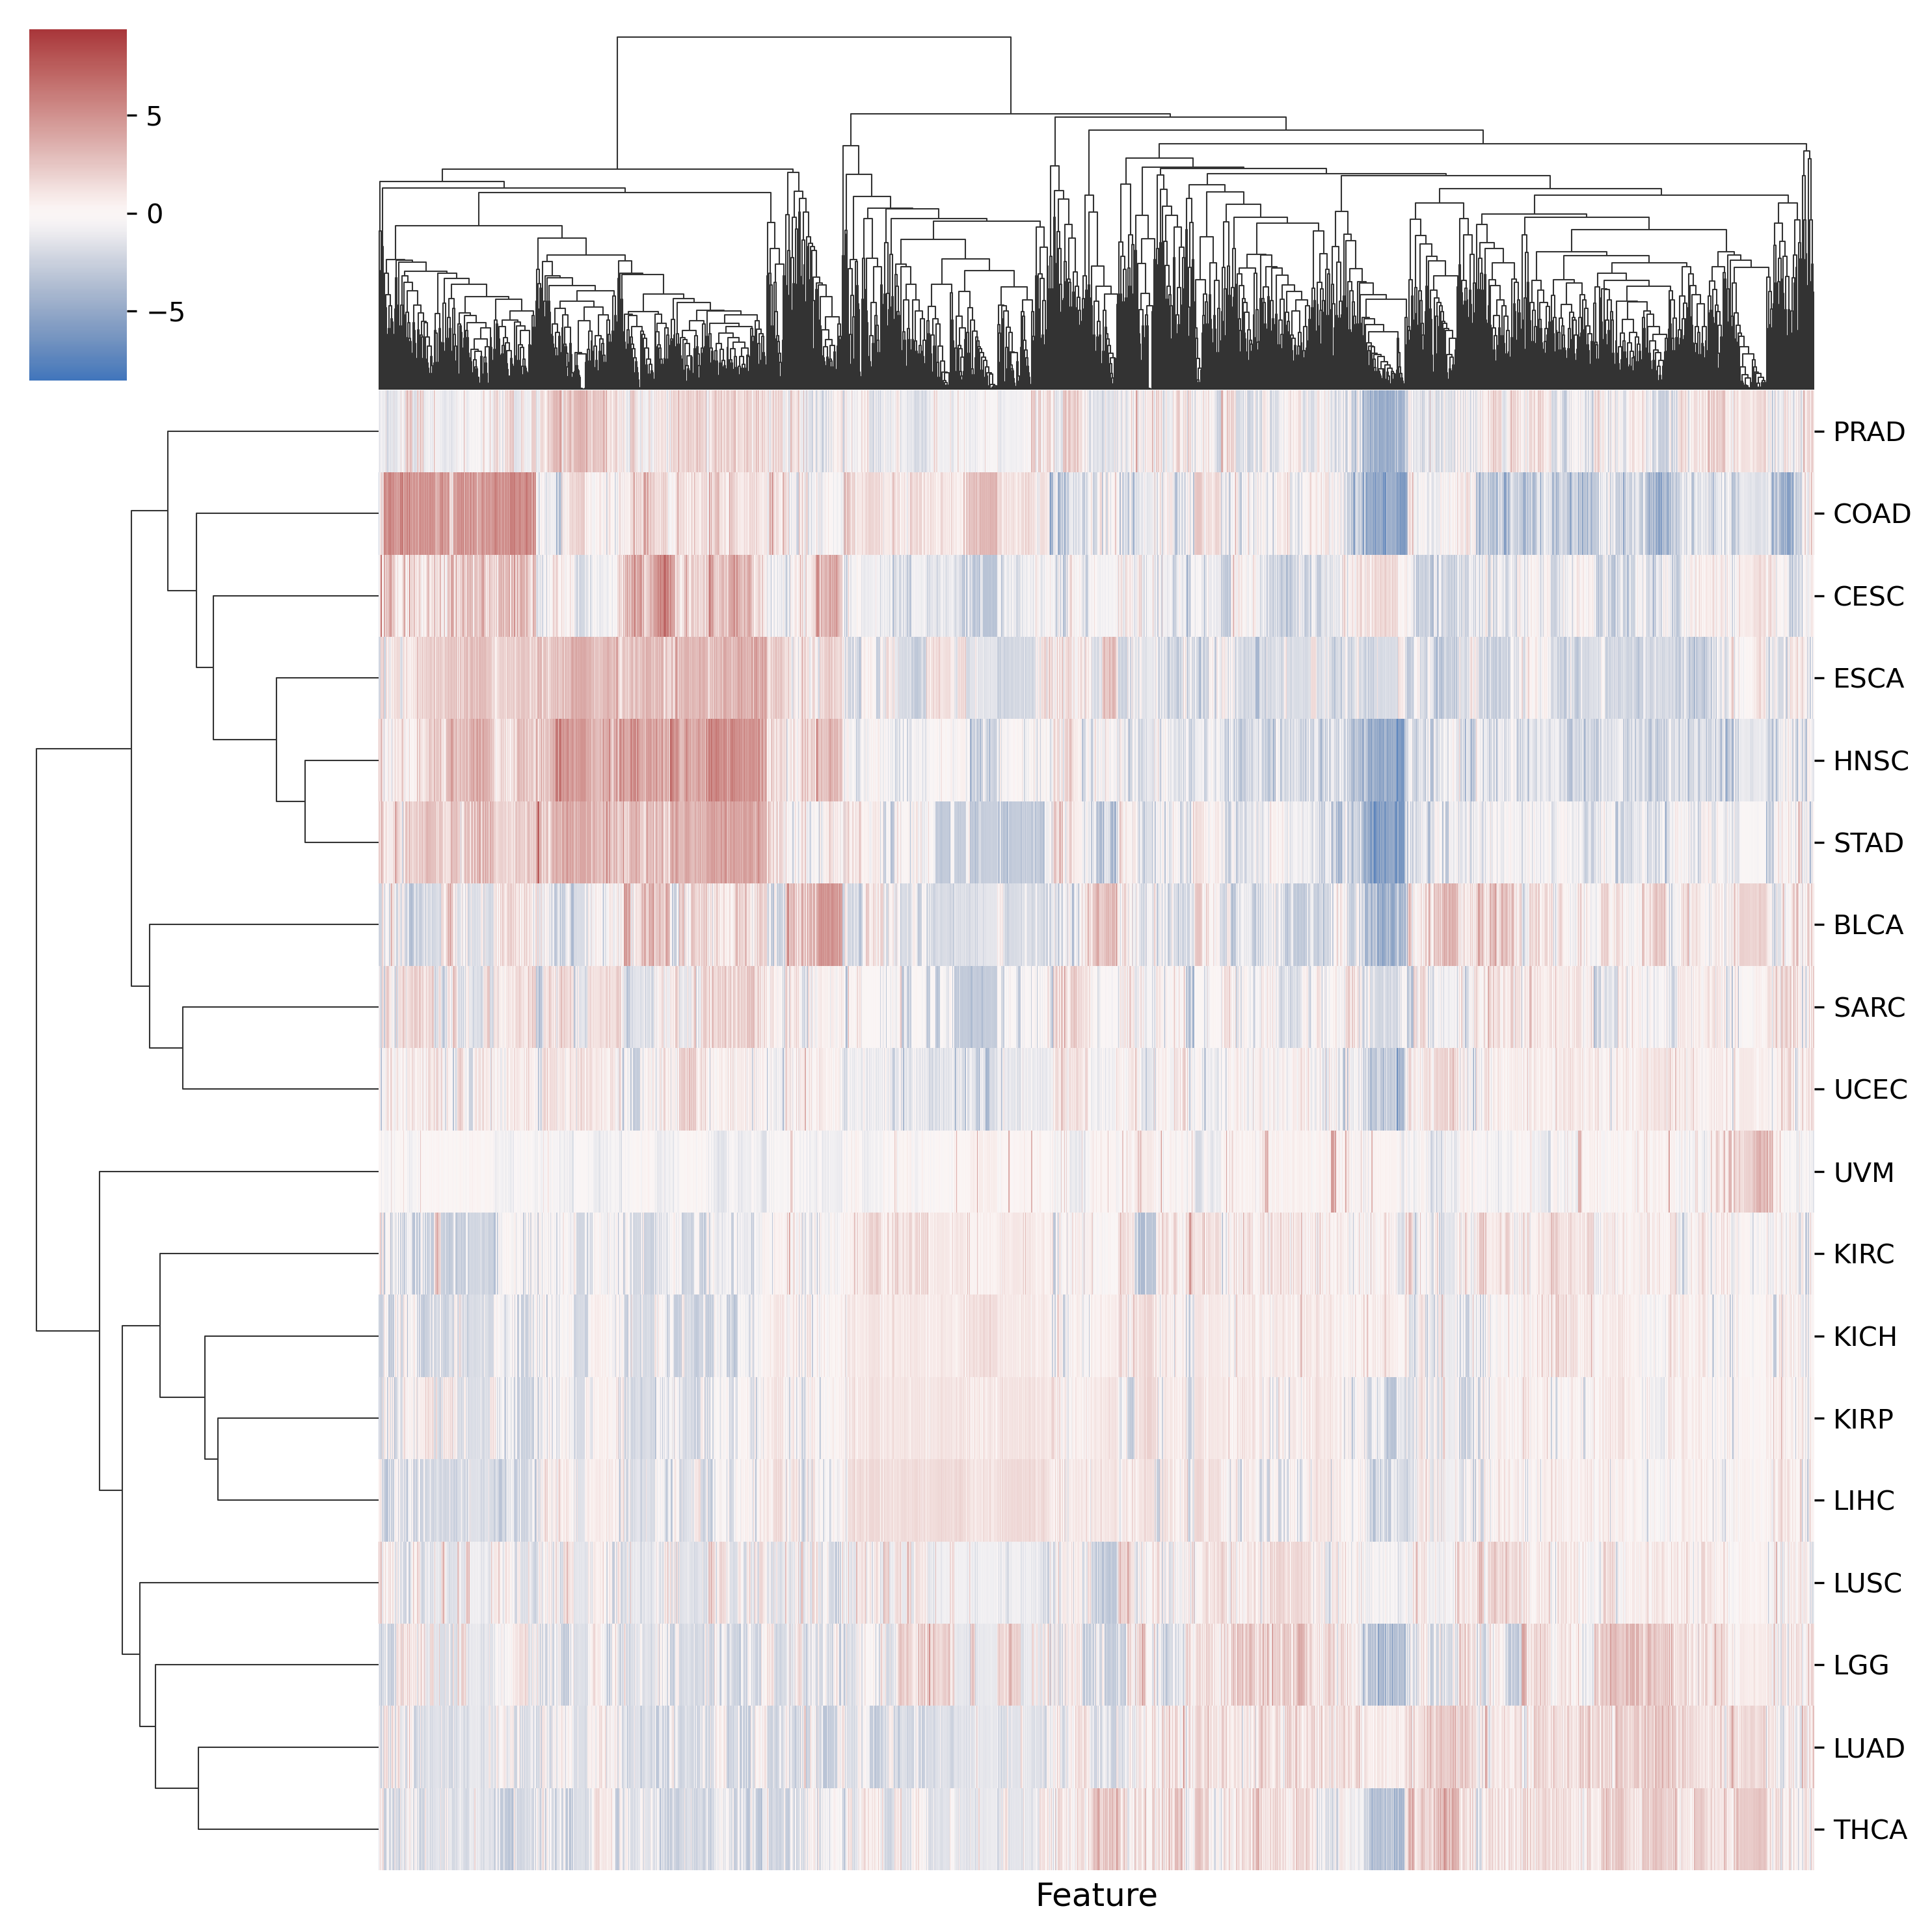

In [12]:
sns.clustermap(
    summ_diff_cent.T,
    cmap="vlag",
    center=0,
    metric="correlation",
    xticklabels=False,
    #z_score=0,
    #vmin=-10,
    #vmax=10
)

plt.savefig("../figures/tcga/cancer_diff_clustermap.pdf")
plt.show()

In [13]:
corr = summ_diff_cent.corr("kendall")
mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

corr.iloc[:5, :5]

,BLCA,CESC,COAD,ESCA,HNSC
BLCA,1.000000,0.119486,-0.014676,0.082720,0.128705
CESC,0.119486,1.000000,0.133701,0.273207,0.285946
COAD,-0.014676,0.133701,1.000000,0.259562,0.348027
ESCA,0.082720,0.273207,0.259562,1.000000,0.484316
HNSC,0.128705,0.285946,0.348027,0.484316,1.000000


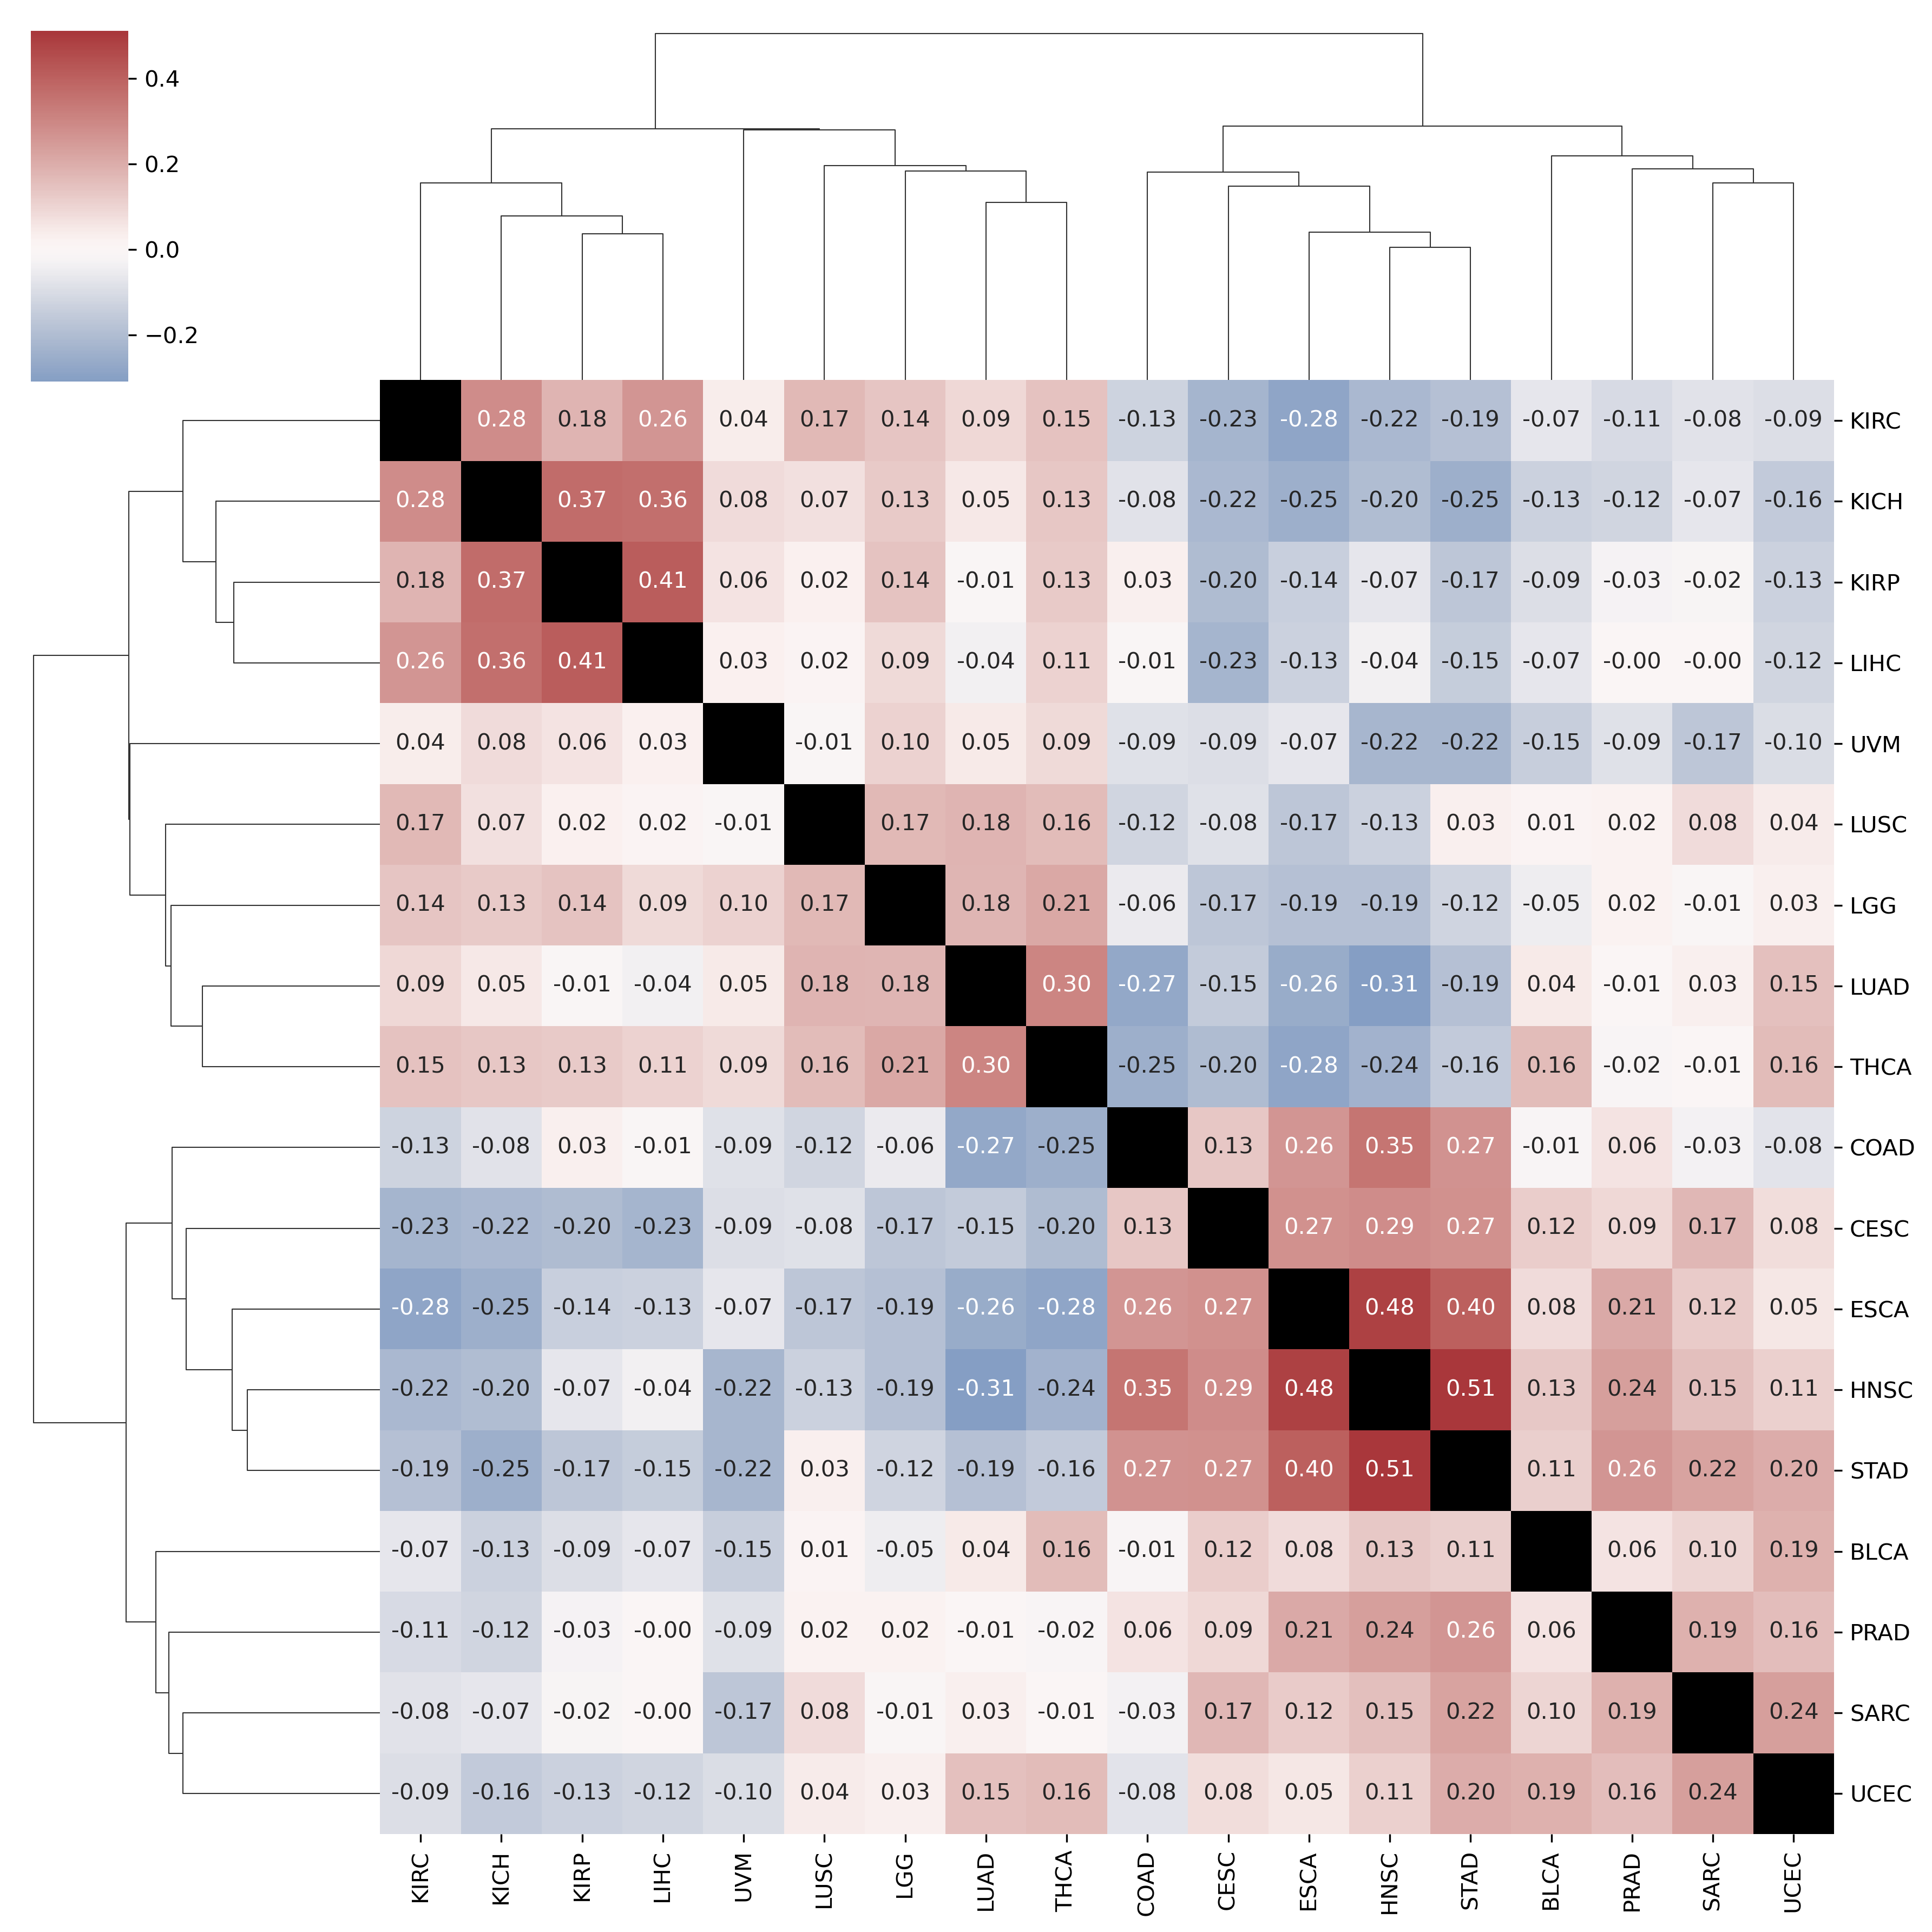

In [14]:
g = sns.clustermap(
    corr,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    figsize=(12, 12),
    mask=mask,
    #dendrogram_ratio=0.2
)
g.ax_heatmap.set_facecolor("black")

plt.savefig("../figures/tcga/cancer_diff_correlation_clustermap.pdf")
plt.show()

In [15]:
summ_diff_std = summ_diff.filter(like="std")
summ_diff_std.head()

,BLCA_std,CESC_std,COAD_std,ESCA_std,HNSC_std,KICH_std,KIRC_std,KIRP_std,LGG_std,LIHC_std,LUAD_std,LUSC_std,PRAD_std,SARC_std,STAD_std,THCA_std,UCEC_std,UVM_std
Feature,,,,,,,,,,,,,,,,,,
G000143845,2.427170,2.324958,2.311108,2.685598,1.800280,2.675452,2.555504,2.699086,3.067291,2.784021,2.946356,3.398437,3.143958,3.400918,2.227340,2.860714,2.944276,3.298936
G009740265,2.300744,2.306272,2.158667,2.722133,1.858020,2.685000,2.563760,2.660318,2.463396,2.659075,3.088532,3.508254,3.288815,3.072347,2.290449,3.008559,2.338097,3.375193
G002370355,2.146078,2.281427,3.021298,3.405991,1.988031,3.185768,2.575637,2.752759,2.563343,2.711329,2.931985,3.339980,3.005388,2.548292,2.177111,2.258369,2.040992,3.524083
G001042675,2.968868,2.188407,3.184904,2.656758,1.783733,2.721239,2.644905,2.761158,3.276169,2.713204,2.488785,3.349009,3.183500,2.521516,2.289744,2.316043,2.178537,3.526639
G000284255,2.301196,3.219614,2.282559,3.587937,1.807293,2.757062,2.312109,3.253879,2.225297,3.261608,2.122095,2.626535,2.434110,3.554600,2.279388,2.023715,2.260910,3.812598


In [16]:
tbl_df = tbl.to_dataframe(dense=True).T
table_clr = pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)

In [17]:
ancombc_res = pd.read_table("../results/tcga/ancombc_results_beta.2.tsv", sep="\t", index_col=0)
ancombc_res = ancombc_res.filter(like="investigation")
ancombc_res.columns = [x.replace("investigation", "") for x in ancombc_res.columns]
print(ancombc_res.shape)
ancombc_res.head()

(2302, 18)


,BLCA,CESC,COAD,ESCA,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,PRAD,SARC,STAD,THCA,UCEC,UVM
G000005845,-5.507995,-4.321303,0.262243,-5.931810,-3.995823,1.916829,2.011022,1.872404,-5.411231,2.664248,-5.147854,-5.051351,-5.747608,1.804457,-5.233349,-5.304707,-3.642732,-5.763646
G000006605,-0.080484,-0.060323,-0.163516,-0.015236,0.018826,-0.030815,0.065618,0.142941,-0.129660,0.254207,-0.149330,-0.051162,-0.090682,3.867061,-0.046945,-0.076329,0.134306,-0.044770
G000006765,-0.472201,-0.195068,0.147681,-0.444889,-0.213397,0.167231,1.148947,-0.180324,-0.103961,-0.486090,-0.227668,1.019306,-0.201730,-0.266665,0.063220,0.021973,-0.392889,-0.329777
G000006925,-5.209834,-4.059849,0.205585,-5.515525,-3.792808,1.776904,1.933666,1.738372,-5.155696,2.532777,-4.974924,-4.928338,-5.384352,1.673420,-4.956858,-5.106877,-3.531615,-5.384032
G000006945,-2.155718,-1.592753,-0.174178,-2.109978,-1.549265,0.515091,0.972953,0.656379,-2.167817,1.212503,-2.194100,-2.186626,-2.117967,0.358130,-2.109050,-2.169302,-1.566882,-2.053774


In [18]:
aldex2_regex = re.compile("model\.investigation([A-Z]+) Estimate")

aldex2_res = pd.read_table("../results/tcga/aldex2_results.2.tsv", sep="\t", index_col=0)
aldex2_res = aldex2_res.filter(like="investigation").filter(like="Estimate")
aldex2_res = aldex2_res.rename(columns=lambda x: aldex2_regex.search(x).groups()[0])
print(aldex2_res.shape)
aldex2_res.head()

(2302, 18)


,BLCA,CESC,COAD,ESCA,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,PRAD,SARC,STAD,THCA,UCEC,UVM
G000005845,-8.785664,-7.235786,0.189095,-10.147629,-7.106750,3.222472,3.144422,3.008665,-8.305769,4.152213,-7.490328,-7.024101,-9.421067,2.834849,-8.379088,-8.201421,-5.531672,-9.655811
G000006605,0.353552,0.255046,-1.200260,0.329663,-0.290453,-0.244587,-0.047744,0.147342,0.346810,0.622413,0.059578,0.277802,0.368582,7.578187,0.134271,0.387395,0.611760,0.480630
G000006765,-0.755829,0.003470,-0.452929,-0.523525,-1.041276,0.367290,2.197323,-0.654528,0.220142,-1.650587,-0.331147,2.481114,-0.090398,-1.254242,0.024354,0.463117,-0.737238,-0.316217
G000006925,-8.400713,-6.888216,0.077566,-9.435584,-6.848989,3.066658,3.079778,2.873513,-8.075962,4.034893,-7.422764,-7.276082,-8.849940,2.691920,-8.075118,-8.097110,-5.569459,-9.062438
G000006945,-4.428519,-3.217078,-0.838144,-4.431144,-3.863746,1.212870,1.586454,1.243731,-4.317882,2.179095,-4.641928,-4.721149,-4.262191,0.755986,-4.573222,-4.420094,-3.076824,-4.142594


In [19]:
import pathlib

deseq2_path = pathlib.Path("../results/tcga/deseq2.2/")
deseq2_invest_files = deseq2_path.glob("*.tsv")
deseq2_dfs = []

for f in deseq2_invest_files:
    invest = f.stem
    _df = pd.read_table(f, sep="\t", index_col=0)
    _df = _df["log2FoldChange"]
    _df.name = invest
    deseq2_dfs.append(_df)

deseq2_res = pd.concat(deseq2_dfs, axis=1)
print(deseq2_res.shape)
deseq2_res.head()

(2302, 18)


,LUSC,PRAD,KIRP,STAD,HNSC,UCEC,BLCA,LGG,KIRC,LIHC,ESCA,THCA,LUAD,CESC,KICH,UVM,SARC,COAD
G000005845,-9.974160,-13.953437,0.854852,-8.286147,-2.031937,-2.445319,-8.535759,-10.063812,1.272307,1.463013,-15.738057,-9.265546,-9.992529,-2.823469,0.518117,-25.133835,-0.452900,-0.357950
G000006605,0.208368,0.139123,1.225061,-0.011359,1.399926,2.186060,-0.703032,0.013165,0.194750,1.156102,1.126400,-0.001836,-0.940131,0.148105,0.189409,0.629520,7.226139,-1.388585
G000006765,5.359700,4.146513,0.167747,3.788177,0.587490,-1.043066,-1.568544,0.715394,3.977316,-1.459549,-0.792132,2.762695,3.563725,0.156140,1.181028,0.057028,-0.316680,0.744779
G000006925,-10.012184,-13.902231,0.756819,-7.932156,-2.125253,-2.442410,-8.454179,-10.019158,1.293263,1.446027,-14.766755,-9.250072,-10.147580,-2.807079,0.434854,-22.680588,-0.509386,-0.336362
G000006945,-5.829818,-5.432436,0.496743,-5.667532,-2.257478,-2.564562,-6.275622,-5.411698,1.040489,1.181952,-5.278901,-6.127629,-6.314518,-2.590555,0.309534,-4.710926,-0.653899,-0.456186


In [20]:
def log_ratio(table, top_feats, bot_feats):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    #lr_df = lr_df.dropna(how="all")
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    return lr_df

In [21]:
from evident.stats import calculate_cohens_d

def get_predictor_df(results_df, n=100):
    predictors = []
    lr_df_dict = dict()

    for invest in investigations:
        col = results_df[invest].sort_values(ascending=False)
        top_n = col.head(n).index
        bot_n = col.tail(n).index
        lr = log_ratio(tbl_df, top_n, bot_n)["log_ratio"]
        lr.name = invest

        _df = md[["investigation"]].assign(log_ratio=lr)
        lr_df_dict[invest] = lr
        _x = _df.query("investigation != @invest")["log_ratio"]
        _y = _df.query("investigation == @invest")["log_ratio"]
        t, p = ss.ttest_ind(_y, _x, alternative="greater")
        
        if p > 0.05:
            print(
                invest,
                f"{t = }, {p = }",
                calculate_cohens_d(_y, _x),
                "BOOP" if p > 0.05 else ""
            )
            
        predictors.append(lr)

    return pd.concat(predictors, axis=1).join(md[["investigation", "data_submitting_center_label"]]), lr_df_dict

In [22]:
tool_predictor_dfs = dict()
tool_lr_df_dicts = dict()

res_dfs = {
    "birdman": summ_diff_cent,
    "aldex2": aldex2_res,
    "ancombc": ancombc_res,
    "deseq2": deseq2_res
}

for tool, _df in res_dfs.items():
    print(tool)
    predictor_df, lr_df_dict = get_predictor_df(_df, 180)
    tool_predictor_dfs[tool] = predictor_df
    tool_lr_df_dicts[tool] = lr_df_dict

birdman
aldex2
ancombc
deseq2


In [23]:
from evident.stats import calculate_cohens_d

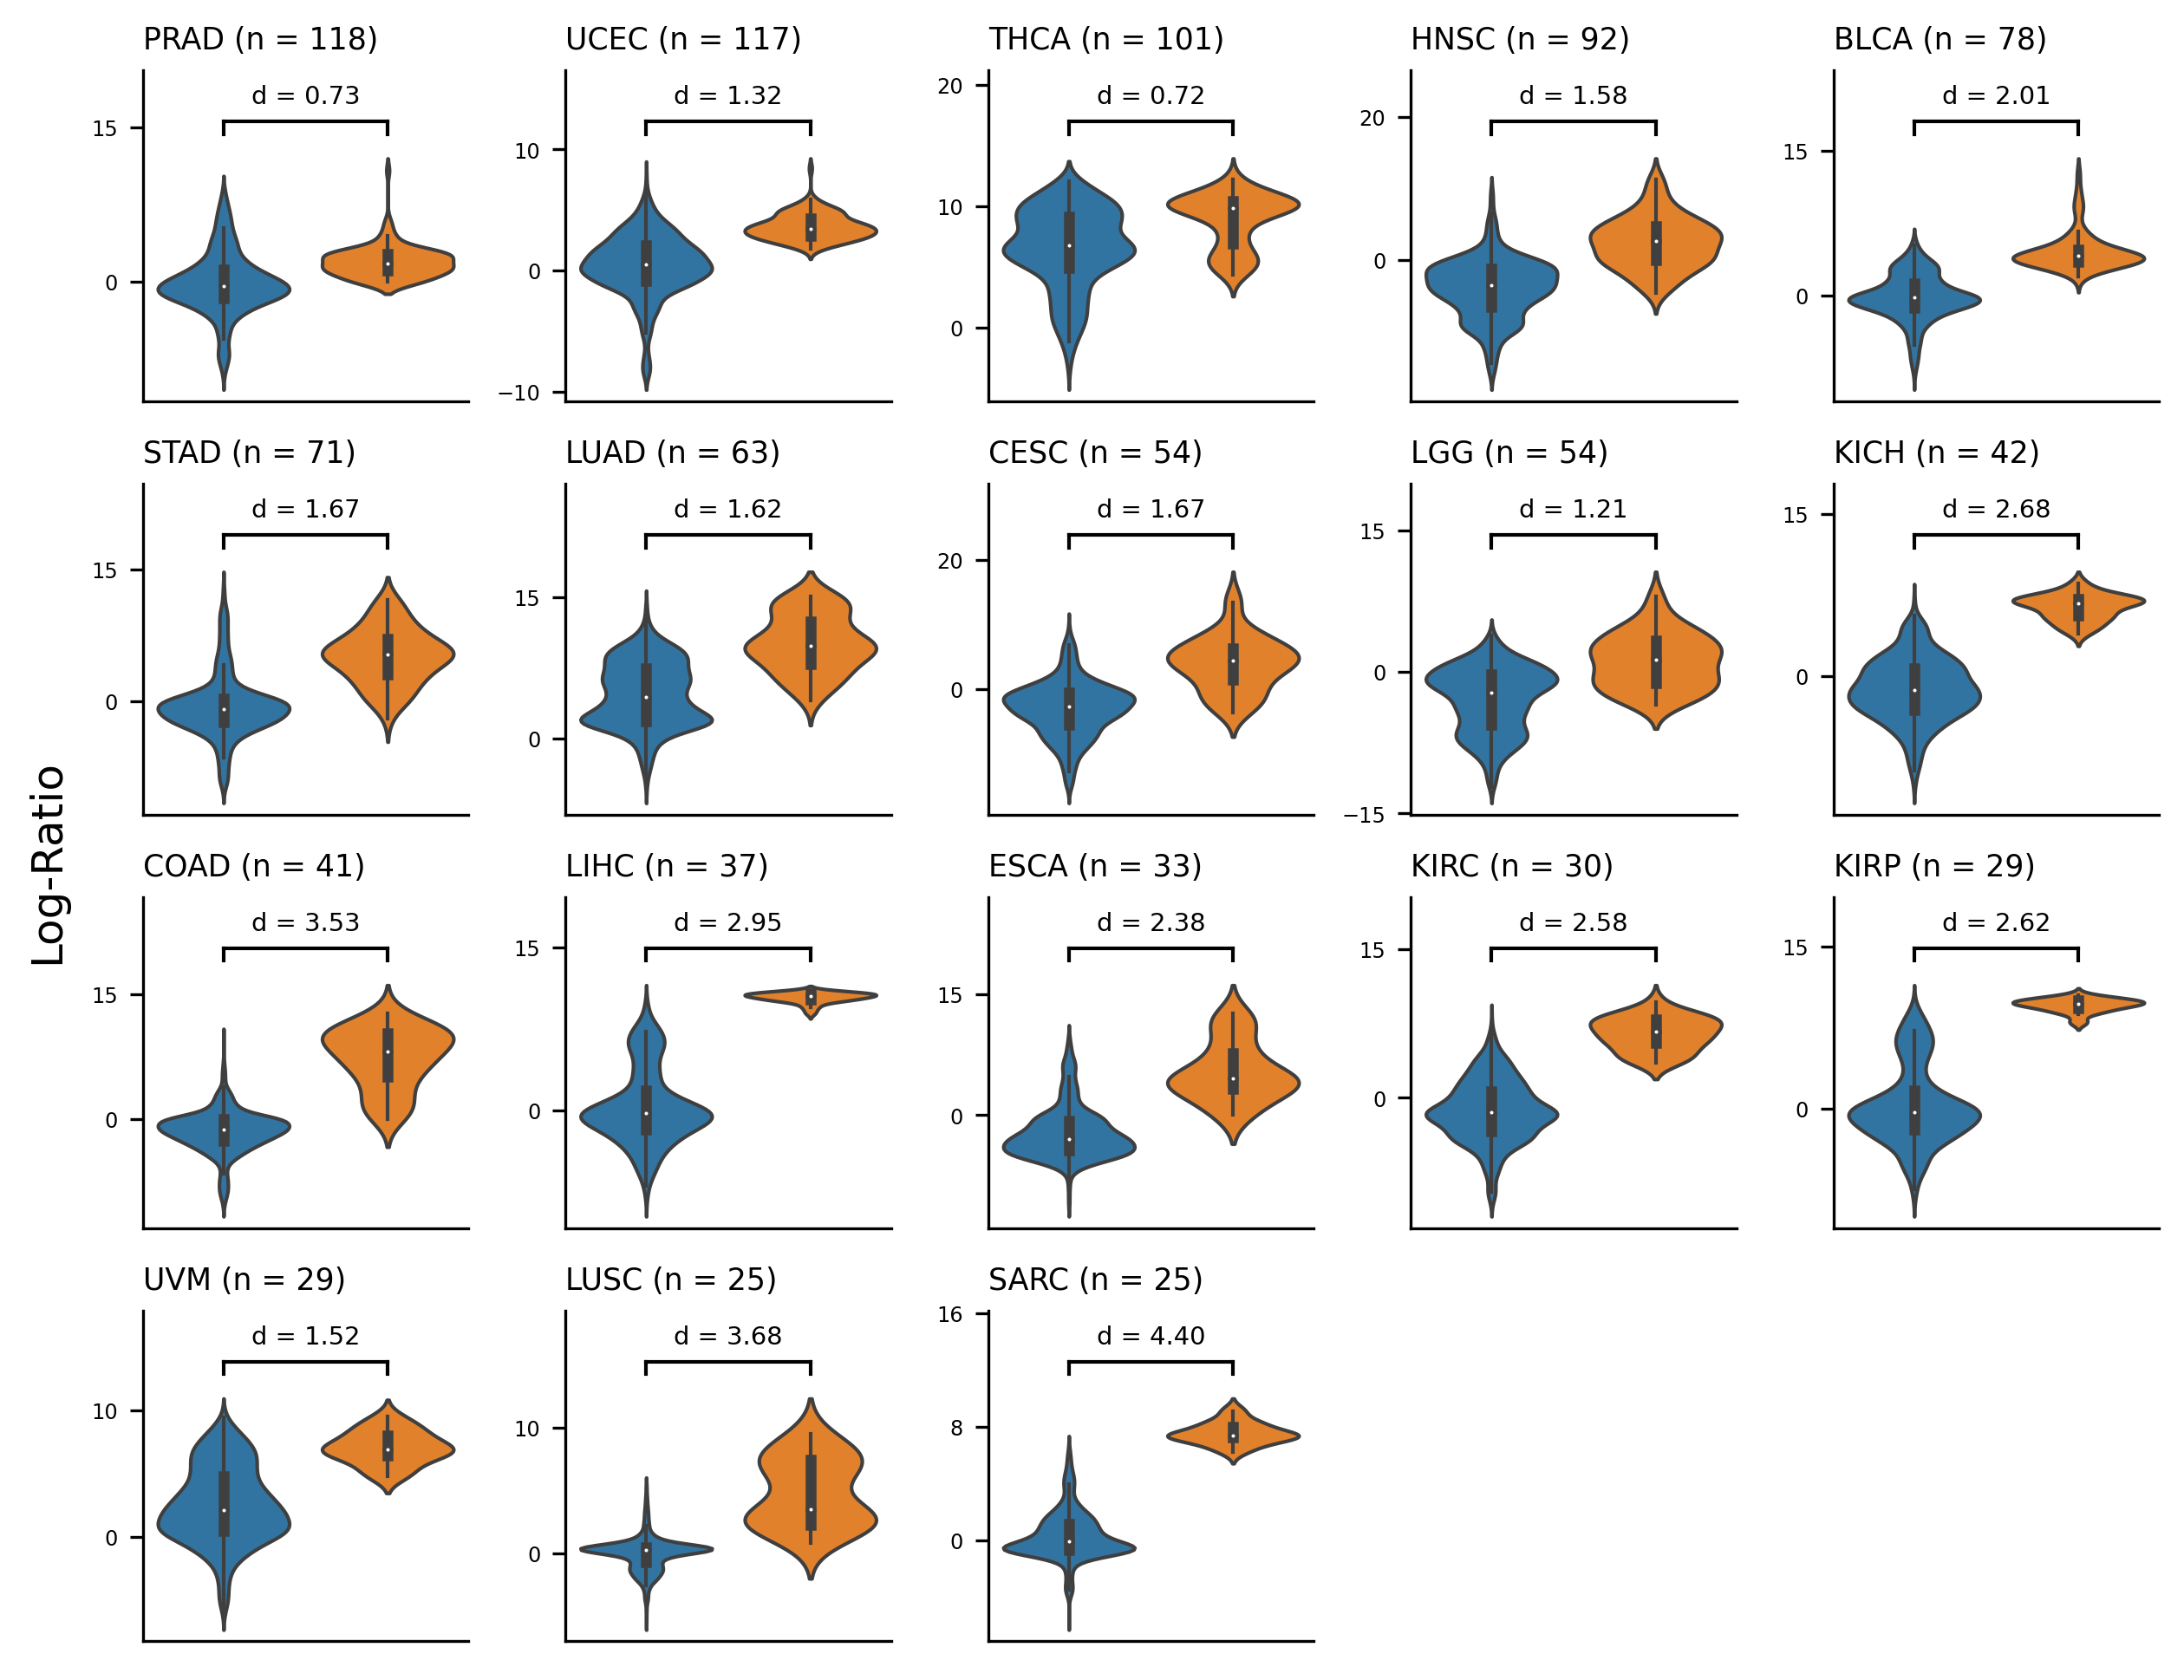

In [24]:
from matplotlib import ticker

fig = plt.figure(figsize=(10, 8))

for i, (invest, _lr) in enumerate(tool_lr_df_dicts["birdman"].items(), start=1):
    ax = fig.add_subplot(4, 5, i)
    _df = pd.concat([_lr, md[["investigation", "data_submitting_center_label"]]], axis=1)
    _df["is_invest"] = _df["investigation"] == invest
    sns.violinplot(
        data=_df,
        x="is_invest",
        y=invest,
        linewidth=1,
        scale="width",
        ax=ax
    )
    ax.xaxis.set_visible(False)
    ax.set_ylabel("")
    ax.tick_params("y", labelsize="xx-small")
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim([ymin, ymax+yrange*0.3])
    
    bot_loc = ymax+yrange*0.05
    top_loc = ymax+yrange*0.1
    ax.plot([0, 1], [top_loc, top_loc], color="k", lw=1)
    ax.plot([0, 0], [bot_loc, top_loc], color="k", lw=1)
    ax.plot([1, 1], [bot_loc, top_loc], color="k", lw=1)
    
    _x = _df.query("is_invest == True")[invest]
    _y = _df.query("is_invest == False")[invest]
    d = calculate_cohens_d(_x, _y)
    ax.text(
        x=0.5,
        y=ymax+yrange*0.15,
        s=f"d = {d:.2f}",
        va="bottom",
        ha="center",
        fontsize="x-small"
    )
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.set_title(f"{invest} (n = {len(_x)})", fontsize="small")

plt.subplots_adjust(wspace=0.3, hspace=0.25)
fig.supylabel("Log-Ratio", x=0.08)

plt.savefig("../figures/tcga/per_cancer_lr_violin.pdf")
plt.show()

In [25]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    fit_intercept=True,
    C=1
)

In [26]:
from sklearn.model_selection import StratifiedKFold

new_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)

scorer = make_scorer(balanced_accuracy_score, adjusted=False)
scoring = {"balanced_accuracy": scorer, "f1_weighted": "f1_weighted"}

In [27]:
to_join = pd.get_dummies(md[["race", "gender"]])
to_join

,race_ASIAN,race_BLACK OR AFRICAN AMERICAN,race_WHITE,gender_FEMALE,gender_MALE
sampleid,,,,,
S13722.58cfa82de4b0c9d6adf6a502,0,0,1,1,0
S13722.58cfa82de4b0c9d6adf6a4ce,1,0,0,1,0
S13722.58cfa82de4b0c9d6adf6a48a,0,0,1,1,0
S13722.58cfa82de4b0c9d6adf6a4d4,0,1,0,1,0
S13722.58cfa82de4b0c9d6adf6a529,0,0,1,1,0
...,...,...,...,...,...
S13722.58cfa831e4b0c9d6adf6ca3c,0,0,1,0,1
S13722.58cfa831e4b0c9d6adf6cc92,0,0,1,0,1
S13722.58cfa832e4b0c9d6adf6ceda,0,0,1,0,1


## Tool Log-Ratios

In [28]:
from collections import defaultdict

tool_perf_dict = defaultdict(dict)

for tool, predictor_df in tool_predictor_dfs.items():
    print(tool)
    for center, _df in predictor_df.groupby("data_submitting_center_label"):
        X = _df[investigations].join(to_join)
        y = LabelEncoder().fit_transform(_df["investigation"])
        scores = cross_validate(model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
        tool_perf_dict[tool][center] = scores
        
        print(center)
        print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
        print("====================================")
    print()

birdman
Baylor College of Medicine
0.8758810189731454 0.8601702975387185
Broad Institute of MIT and Harvard
0.7116313340723065 0.6616730691240494
Harvard Medical School
0.7811499714220801 0.7493811299957545
MD Anderson - Institute for Applied Cancer Science
0.8677252365181474 0.7362062855445207
Washington University School of Medicine
0.9006633580709759 0.9037990196078433

aldex2
Baylor College of Medicine
0.6228852330138823 0.6309710172868067
Broad Institute of MIT and Harvard
0.573744806549689 0.5025276792923852
Harvard Medical School
0.69983464884333 0.6314940432499722
MD Anderson - Institute for Applied Cancer Science
0.781027840070551 0.6663525992534175
Washington University School of Medicine
0.7421456740179486 0.681692162004662

ancombc
Baylor College of Medicine
0.6112778321200587 0.629188034188034
Broad Institute of MIT and Harvard
0.5258786153941516 0.47206587167371483
Harvard Medical School
0.7092128334021646 0.6563226996981938
MD Anderson - Institute for Applied Cancer Scie

## CLR Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state=63, n_estimators=100)
rf_scores = dict()

for center, _df in md.groupby("data_submitting_center_label"):
    idx = _df.index
    
    # Remove feats with all zeros before performing CLR
    X = tbl_df.loc[idx]
    non_zero = tbl_df.loc[idx].any()
    ids_to_keep = non_zero[non_zero].index
    X = X.loc[:, ids_to_keep]
    X = pd.DataFrame(clr(X.values + 1), index=X.index, columns=X.columns)
    X = X.join(to_join)
    
    y = LabelEncoder().fit_transform(_df.loc[idx]["investigation"])
    scores = cross_validate(rf_model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
    rf_scores[center] = scores
    print(X.shape)
    print(center)
    print(len(np.unique(y)))
    print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
    print("=======================")

(174, 2279)
Baylor College of Medicine
6
0.728928061387524 0.7195499432341538
(159, 2121)
Broad Institute of MIT and Harvard
9
0.5880894250266536 0.5196583155406684
(489, 2285)
Harvard Medical School
11
0.6731501134402842 0.5988808040151914
(167, 1953)
MD Anderson - Institute for Applied Cancer Science
7
0.6629360058928577 0.5478443618276657
(135, 2270)
Washington University School of Medicine
4
0.7100273374120457 0.6306577368709722


In [30]:
centers_short_map = {
    "Washington University School of Medicine": "WUSTL",
    "Broad Institute of MIT and Harvard": "BI",
    "Baylor College of Medicine": "BCM",
    "Harvard Medical School": "HMS",
    "MD Anderson - Institute for Applied Cancer Science": "MDA"
}

In [31]:
invest_count_per_center = dict(
    md
    .groupby(["data_submitting_center_label"])
    .apply(lambda x: len(x["investigation"].unique()))
)

In [32]:
tool_acc_dfs = []

for tool, perf_dict in tool_perf_dict.items():
    _df = pd.DataFrame.from_dict(perf_dict)
    _df =  (
        _df
        .apply(pd.Series.explode)
        .reset_index()
        .rename(columns={"index": "metric"})
        .melt(id_vars=["metric"], var_name="center")
        .assign(model=tool_text_styling_dict[tool])
        .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
    )
    tool_acc_dfs.append(_df)
    
rf_score_df = pd.DataFrame.from_dict(rf_scores)
rf_score_df = (
    rf_score_df
    .apply(pd.Series.explode)
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars=["metric"], var_name="center")
    .assign(model="Random Forest")
    .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
)

all_perf_df = pd.concat(tool_acc_dfs + [rf_score_df]).reset_index(drop=True)

all_perf_df["metric"] = all_perf_df["metric"].replace({
    "test_f1_weighted": "Classifier F1 Score",
    "test_balanced_accuracy": "Classifier Accuracy"
})

def add_num_cancer_types(row):
    invest_count = invest_count_per_center[row["center"]]
    return f"{row['center_short']}\n({invest_count} Cancer Types)"

def add_num_samples(center):
    return md.query("data_submitting_center_label == @center").shape[0]

all_perf_df["N"] = all_perf_df["center"].map(add_num_samples)
all_perf_df["center_short"] = all_perf_df["center"].map(centers_short_map)
all_perf_df["center_short"] = all_perf_df.apply(add_num_cancer_types, axis=1)

all_perf_df.head()

,metric,center,value,model,N,center_short
0,Classifier Accuracy,Baylor College of Medicine,0.897354,BIRDMAn,174,BCM\n(6 Cancer Types)
1,Classifier Accuracy,Baylor College of Medicine,0.845868,BIRDMAn,174,BCM\n(6 Cancer Types)
2,Classifier Accuracy,Baylor College of Medicine,0.847884,BIRDMAn,174,BCM\n(6 Cancer Types)
3,Classifier Accuracy,Baylor College of Medicine,0.905228,BIRDMAn,174,BCM\n(6 Cancer Types)
4,Classifier Accuracy,Baylor College of Medicine,0.821429,BIRDMAn,174,BCM\n(6 Cancer Types)


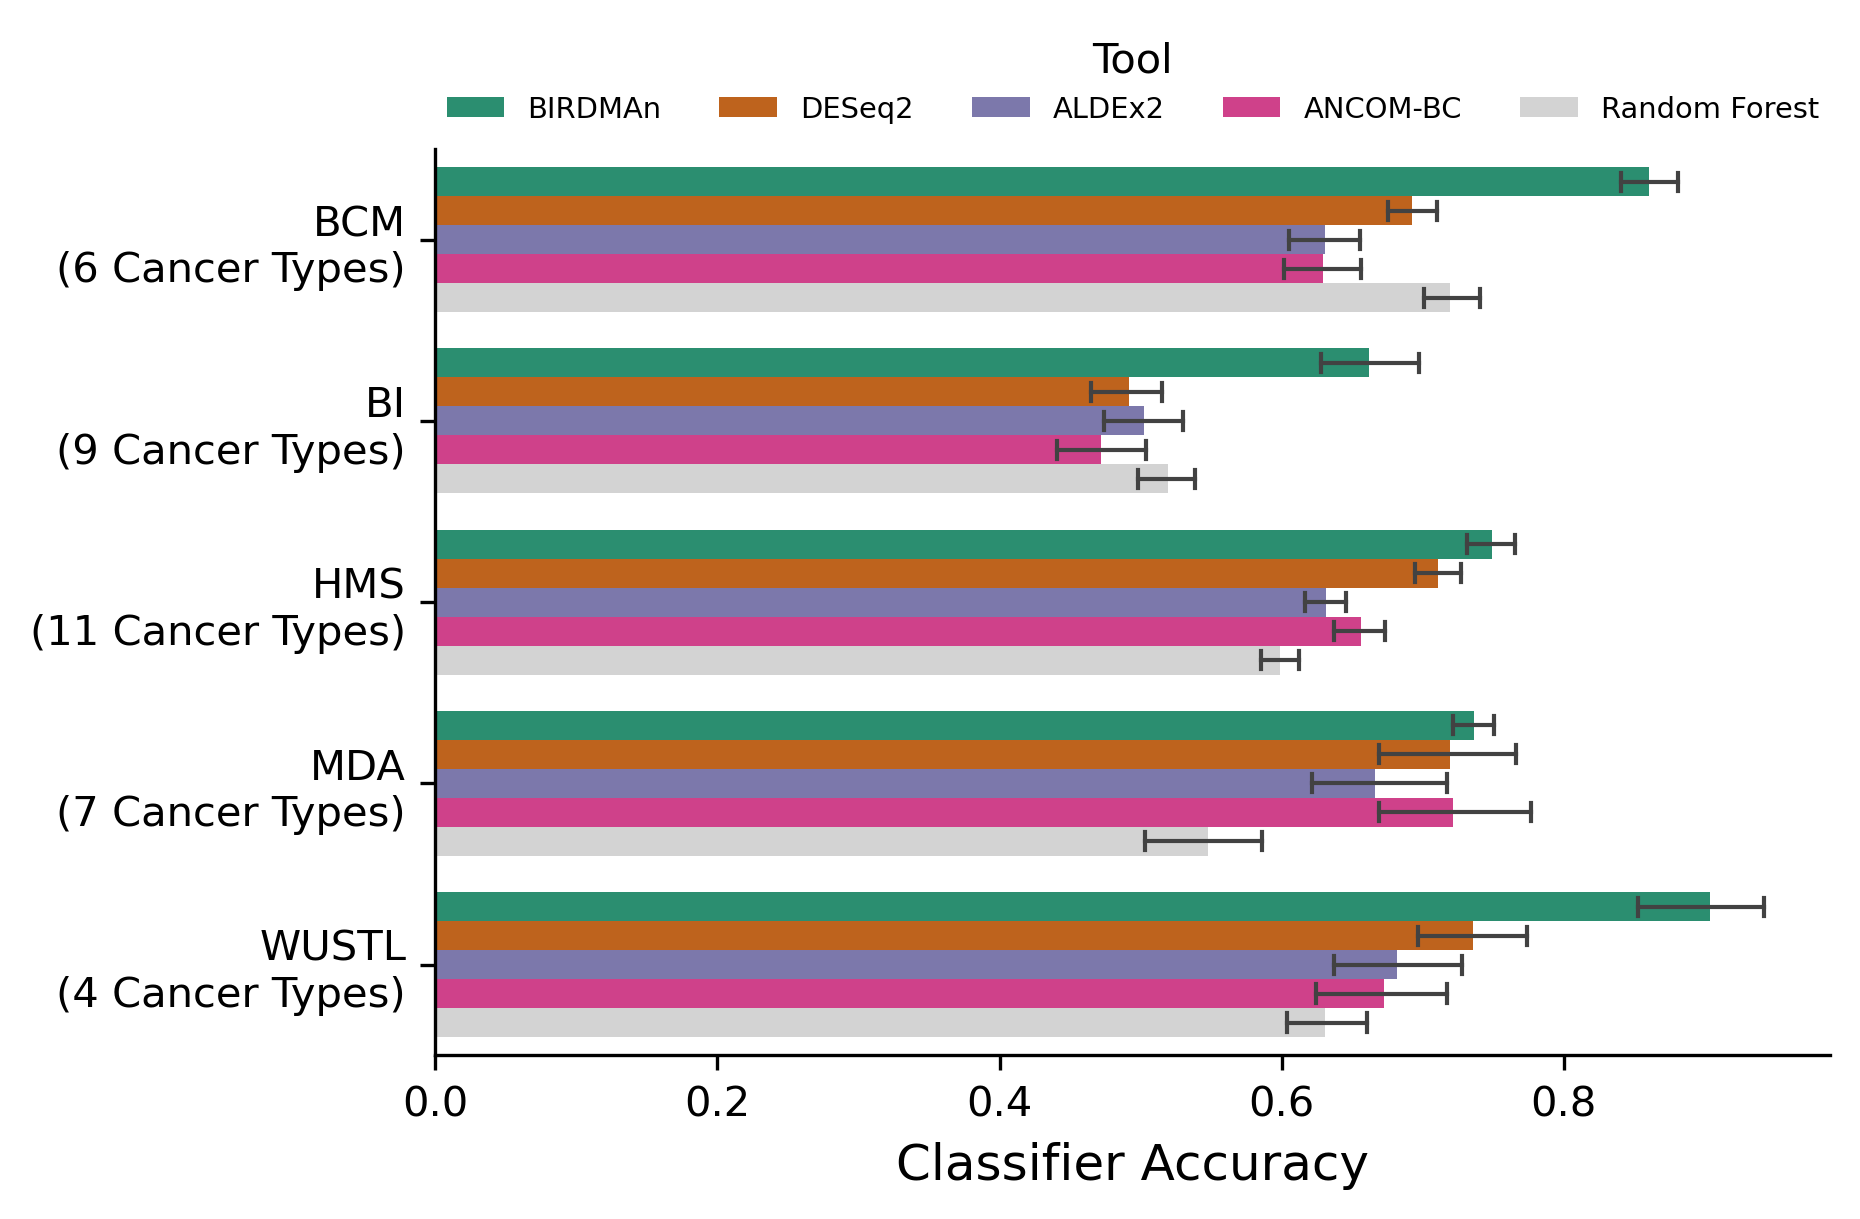

In [33]:
from helper import tool_palette, tool_text_styling_dict

tool_palette["Random Forest"] = "lightgray"
order = ["BIRDMAn", "DESeq2", "ALDEx2", "ANCOM-BC", "Random Forest"]

fig, ax = plt.subplots(1, 1)

sns.barplot(
    data=all_perf_df[all_perf_df["metric"].str.contains("Accuracy")],
    x="value",
    y="center_short",
    hue="model",
    palette=tool_palette,
    hue_order=order,
    linewidth=1,
    errwidth=1,
    capsize=0.1,
    ax=ax
)

ax.set_ylabel("")
ax.set_xlabel("Classifier Accuracy")
ax.legend(
    bbox_to_anchor=[0.5, 1],
    ncol=5,
    loc="lower center",
    frameon=False,
    title="Tool"
)

#plt.savefig("../figures/tcga/per_center_classifier_perf.pdf")
plt.show()

In [34]:
perf_mat = (
    all_perf_df
    .query("metric == 'Classifier Accuracy'")
    .groupby(["center_short", "model"])["value"]
    .apply(lambda x: x.mean())
    .reset_index()
    .pivot(index="center_short", columns="model", values="value")
    .loc[:, order]
)
perf_mat

model,BIRDMAn,DESeq2,ALDEx2,ANCOM-BC,Random Forest
center_short,,,,,
BCM\n(6 Cancer Types),0.860170,0.692427,0.630971,0.629188,0.719550
BI\n(9 Cancer Types),0.661673,0.491635,0.502528,0.472066,0.519658
HMS\n(11 Cancer Types),0.749381,0.711112,0.631494,0.656323,0.598881
MDA\n(7 Cancer Types),0.736206,0.719161,0.666353,0.721707,0.547844
WUSTL\n(4 Cancer Types),0.903799,0.735955,0.681692,0.672697,0.630658


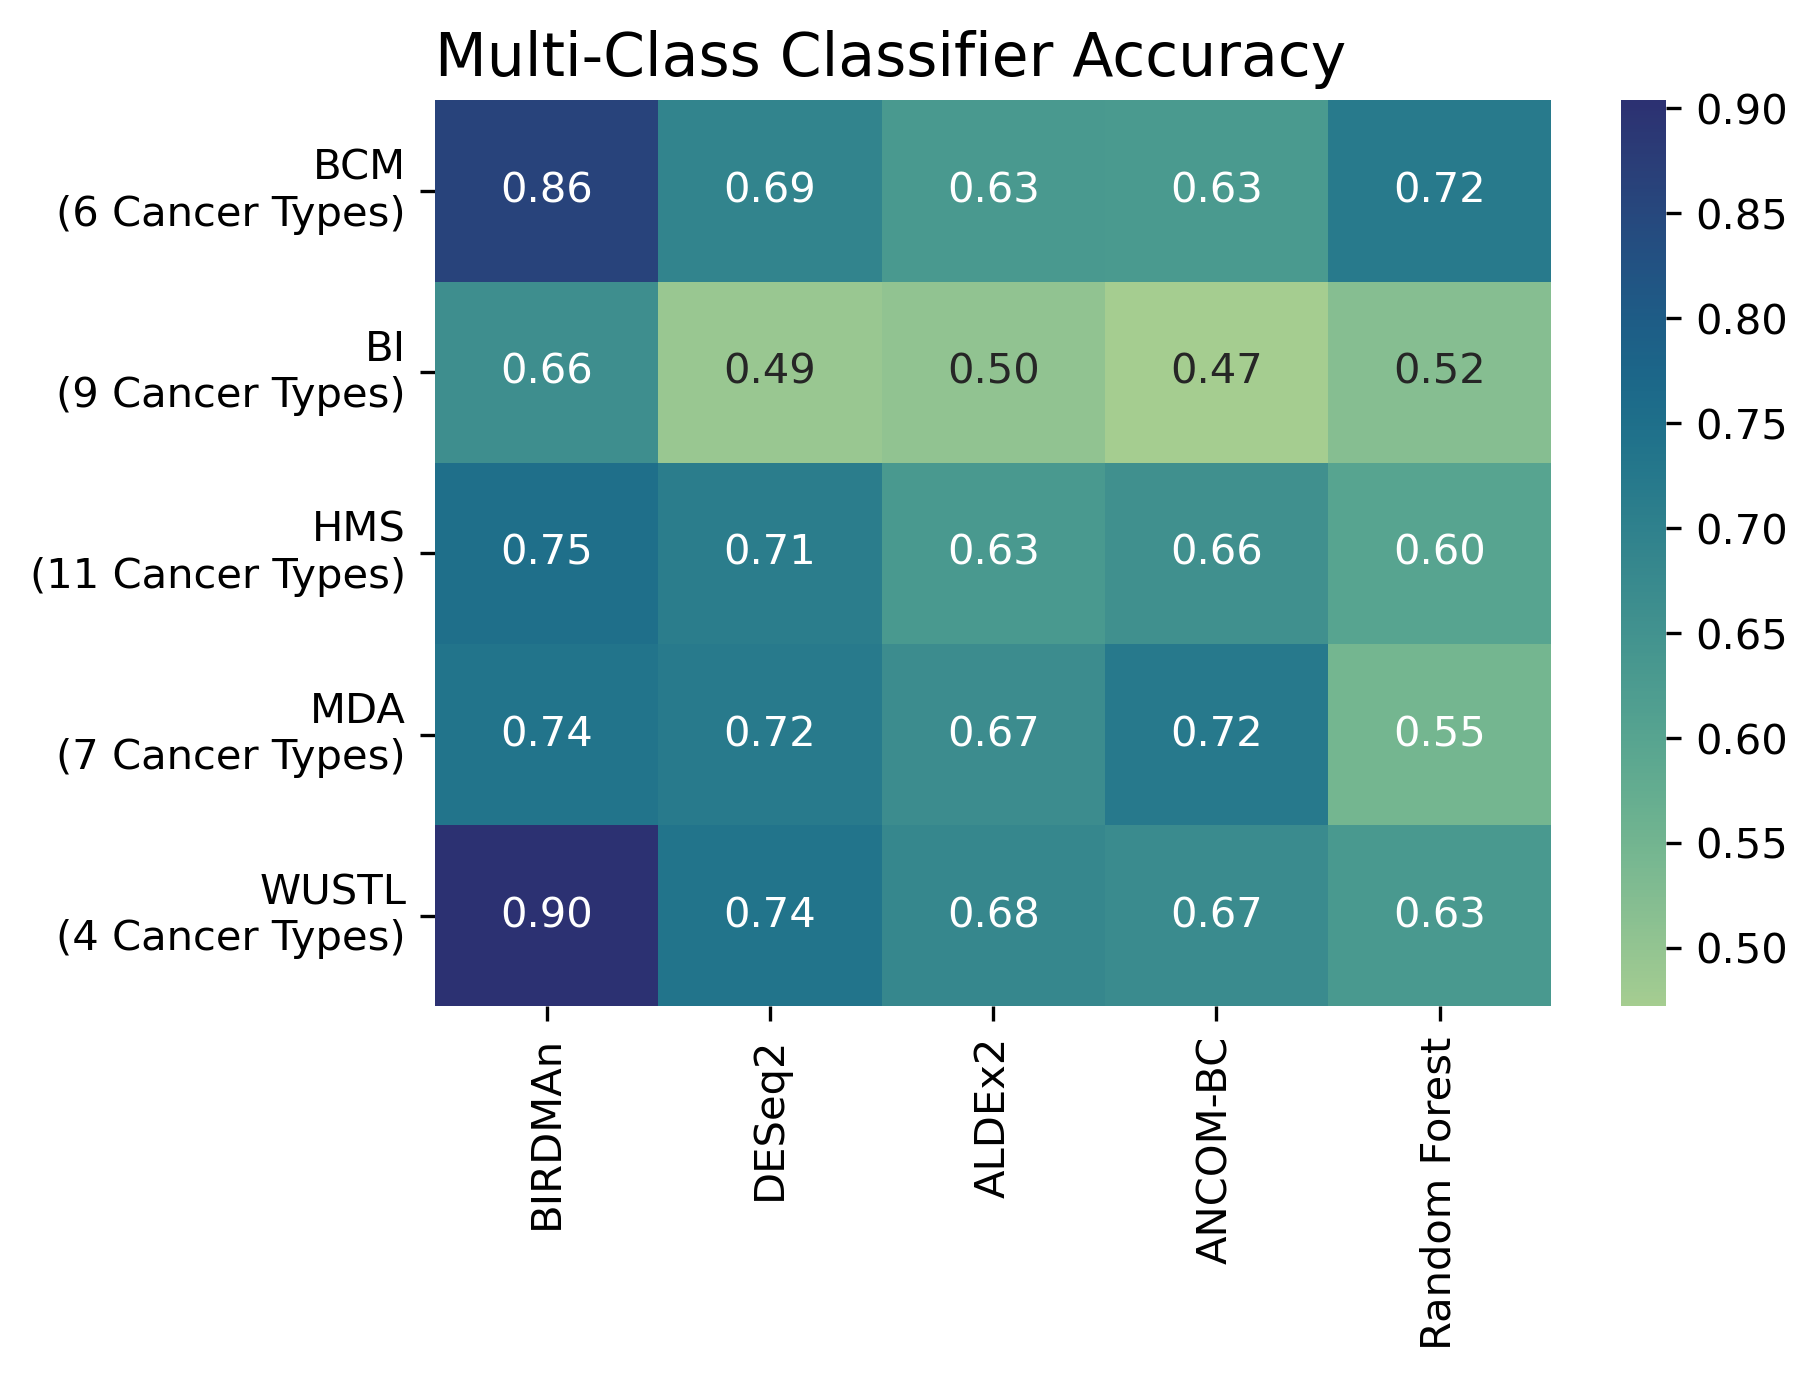

In [35]:
fig, ax = plt.subplots(1, 1)

sns.heatmap(perf_mat, annot=True, cmap="crest", ax=ax, fmt=".2f")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Multi-Class Classifier Accuracy")

plt.savefig("../figures/tcga/per_center_classifier_perf.pdf")
plt.show()

In [36]:
all_predictor_dfs = []

for tool, predictor_df in tool_predictor_dfs.items():
    all_predictor_dfs.append((
        predictor_df
        .assign(tool=tool_text_styling_dict[tool]).reset_index()
        .rename(columns={"index": "sample_name"})
    ))

all_predictor_df = pd.concat(all_predictor_dfs)
all_predictor_df.head()

,sample_name,PRAD,UCEC,THCA,HNSC,BLCA,STAD,LUAD,CESC,LGG,...,LIHC,ESCA,KIRC,KIRP,UVM,LUSC,SARC,investigation,data_submitting_center_label,tool
0,S13722.58cfa82de4b0c9d6adf6a502,-0.107809,3.178054,5.532122,-0.970134,0.903257,-0.937746,1.745115,-1.464072,-0.113023,...,5.503677,-3.547514,1.814378,4.793642,-0.133131,-0.843012,0.565808,UCEC,Washington University School of Medicine,BIRDMAn
1,S13722.58cfa82de4b0c9d6adf6a4ce,0.168172,-0.859377,5.853707,-2.631837,-2.205530,-4.079934,1.361473,-2.520946,0.699271,...,0.994682,-5.654143,5.862006,0.328700,1.830824,0.595079,-3.375513,BRCA,Washington University School of Medicine,BIRDMAn
2,S13722.58cfa82de4b0c9d6adf6a48a,2.028518,2.546761,5.824422,0.823869,-0.743989,-0.190391,0.957979,2.903569,-1.268982,...,2.603718,-4.185677,2.861774,2.778361,2.301665,0.135005,0.395515,UCEC,Washington University School of Medicine,BIRDMAn
3,S13722.58cfa82de4b0c9d6adf6a4d4,1.084370,2.388987,7.210798,-0.923494,-2.351987,-1.725777,1.259800,2.470265,-0.871758,...,2.917614,-5.494212,0.046665,2.753280,3.042890,0.749461,-0.935817,UCEC,Washington University School of Medicine,BIRDMAn
4,S13722.58cfa82de4b0c9d6adf6a529,0.074874,2.197225,6.903111,0.000000,-2.100514,-1.189584,1.365748,-0.456758,-0.972886,...,5.650733,-4.344315,3.486355,5.485913,1.250671,-0.176351,0.341303,UCEC,Washington University School of Medicine,BIRDMAn


In [37]:
results_dfs = []
for i, center in enumerate(centers, start=1):    
    results_dict = defaultdict(dict)
    _df_center = all_predictor_df[all_predictor_df["data_submitting_center_label"] == center]
    for invest in _df_center["investigation"].unique():
        if invest == "BRCA":
            continue
            
        for tool, _df in _df_center.groupby("tool"):
            x = _df[_df["investigation"] == invest][invest]
            y = _df[_df["investigation"] != invest][invest]

            t, p = ss.ttest_ind(x, y, alternative="greater")
            results_dict[tool][invest] = -np.log10(p)
    
    results = (
        pd.DataFrame.from_dict(results_dict)
        .T
        .reset_index()
        .rename(columns={"index": "tool"})
        .melt(id_vars="tool", value_name="neg_log10_p", var_name="investigation")
        .assign(center=center)
    )
    results_dfs.append(results)
    
all_result_df = pd.concat(results_dfs)
all_result_df["center"] = all_result_df["center"].map(centers_short_map)

In [38]:
all_result_df.head()

,tool,investigation,neg_log10_p,center
0,ALDEx2,UCEC,0.377436,WUSTL
1,ANCOM-BC,UCEC,0.354730,WUSTL
2,BIRDMAn,UCEC,5.493166,WUSTL
3,DESeq2,UCEC,5.060148,WUSTL
4,ALDEx2,SARC,3.960880,WUSTL


In [39]:
all_result_df.groupby("tool")["neg_log10_p"].mean()

tool
ALDEx2       6.934412
ANCOM-BC     7.406041
BIRDMAn     16.787931
DESeq2       9.597348
Name: neg_log10_p, dtype: float64

In [40]:
all_result_df.groupby(["center", "tool"])["neg_log10_p"].mean()

center  tool    
BCM     ALDEx2       8.970233
        ANCOM-BC     9.551916
        BIRDMAn     23.503100
        DESeq2       8.626238
BI      ALDEx2       4.198439
        ANCOM-BC     5.103706
        BIRDMAn      9.177046
        DESeq2       5.579699
HMS     ALDEx2       9.305945
        ANCOM-BC    11.858276
        BIRDMAn     18.362017
        DESeq2      13.621011
MDA     ALDEx2       5.106671
        ANCOM-BC     3.459068
        BIRDMAn     14.493371
        DESeq2       8.535225
WUSTL   ALDEx2       6.821064
        ANCOM-BC     3.074457
        BIRDMAn     25.532412
        DESeq2      12.304549
Name: neg_log10_p, dtype: float64

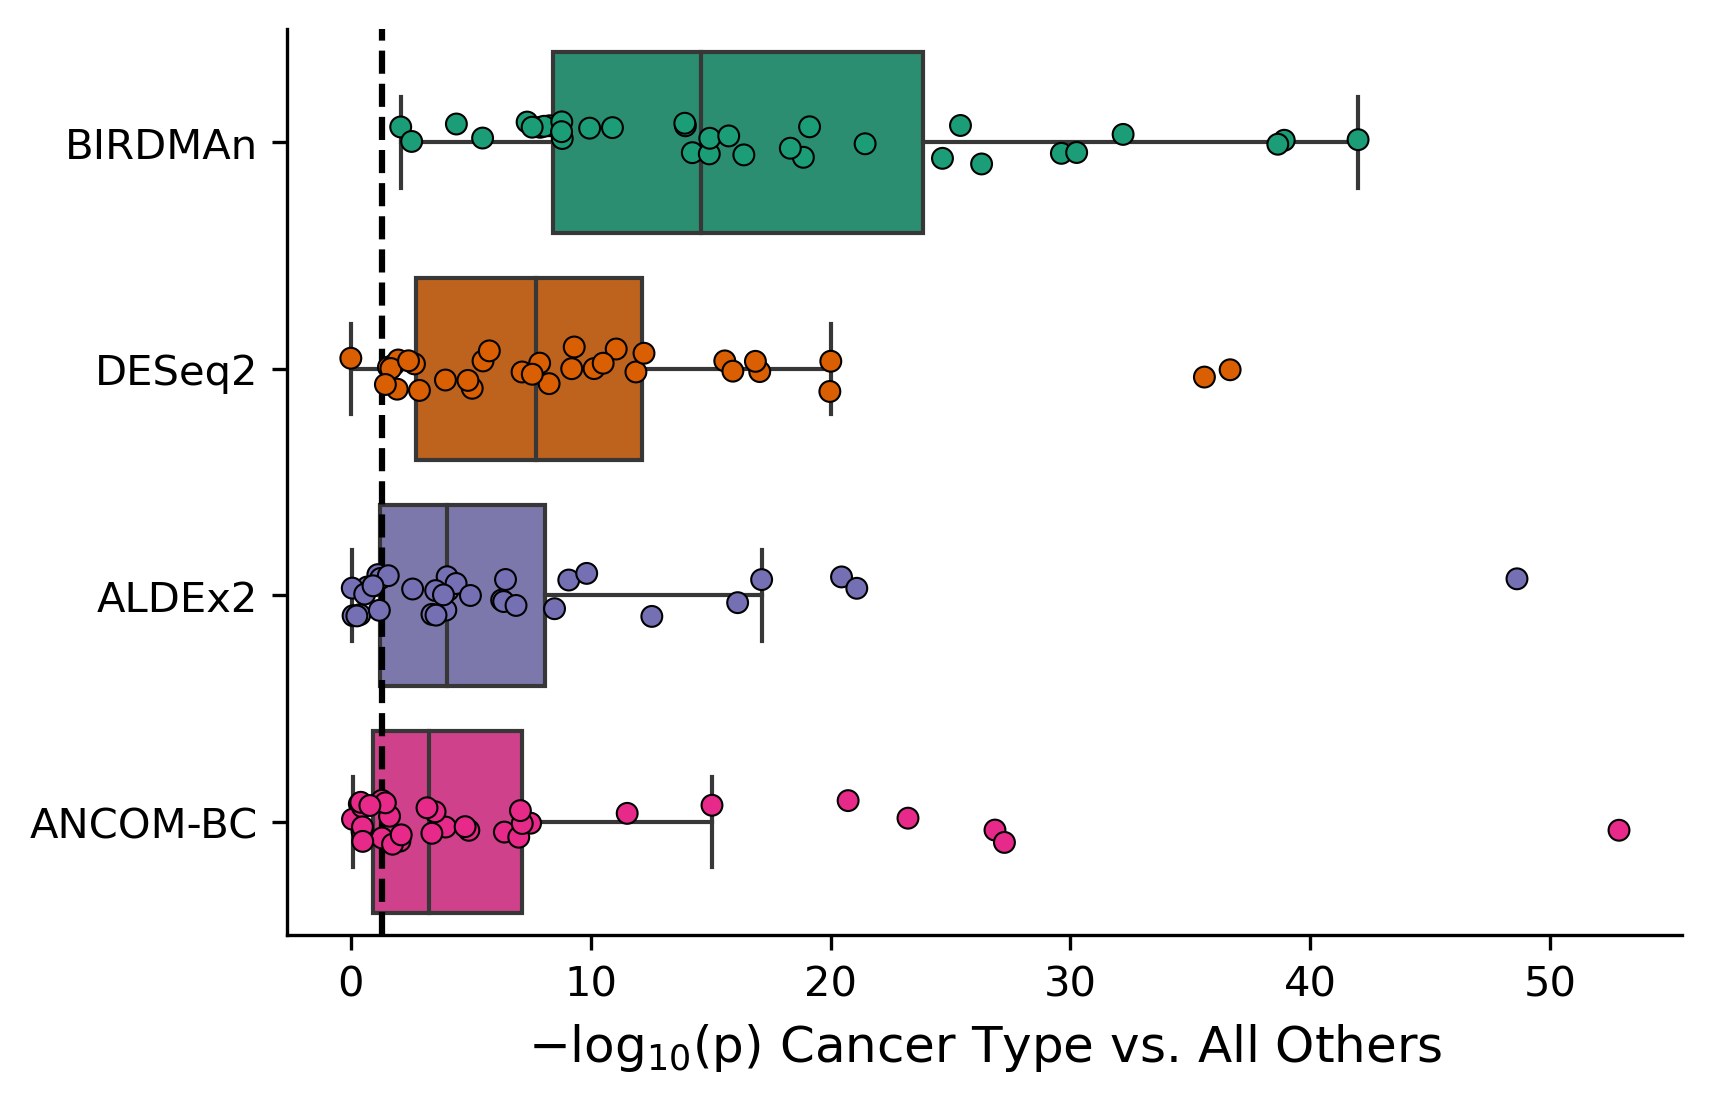

In [41]:
fig, ax = plt.subplots(1, 1)

sns.boxplot(
    data=all_result_df,
    x="neg_log10_p",
    y="tool",
    order=order[:-1],
    palette=tool_palette,
    linewidth=1,
    showfliers=False,
    ax=ax
)

sns.stripplot(
    data=all_result_df,
    x="neg_log10_p",
    y="tool",
    order=order[:-1],
    edgecolor="black",
    linewidth=0.5,
    palette=tool_palette,
    ax=ax
)

ax.axvline(-np.log10(0.05), ls="--", color="k")
ax.set_ylabel("")
ax.set_xlabel(r"$-\log_{10}\left(\mathrm{p}\right)$ Cancer Type vs. All Others")

plt.savefig("../figures/tcga/neg_log10_p_by_tool.pdf")
plt.show()

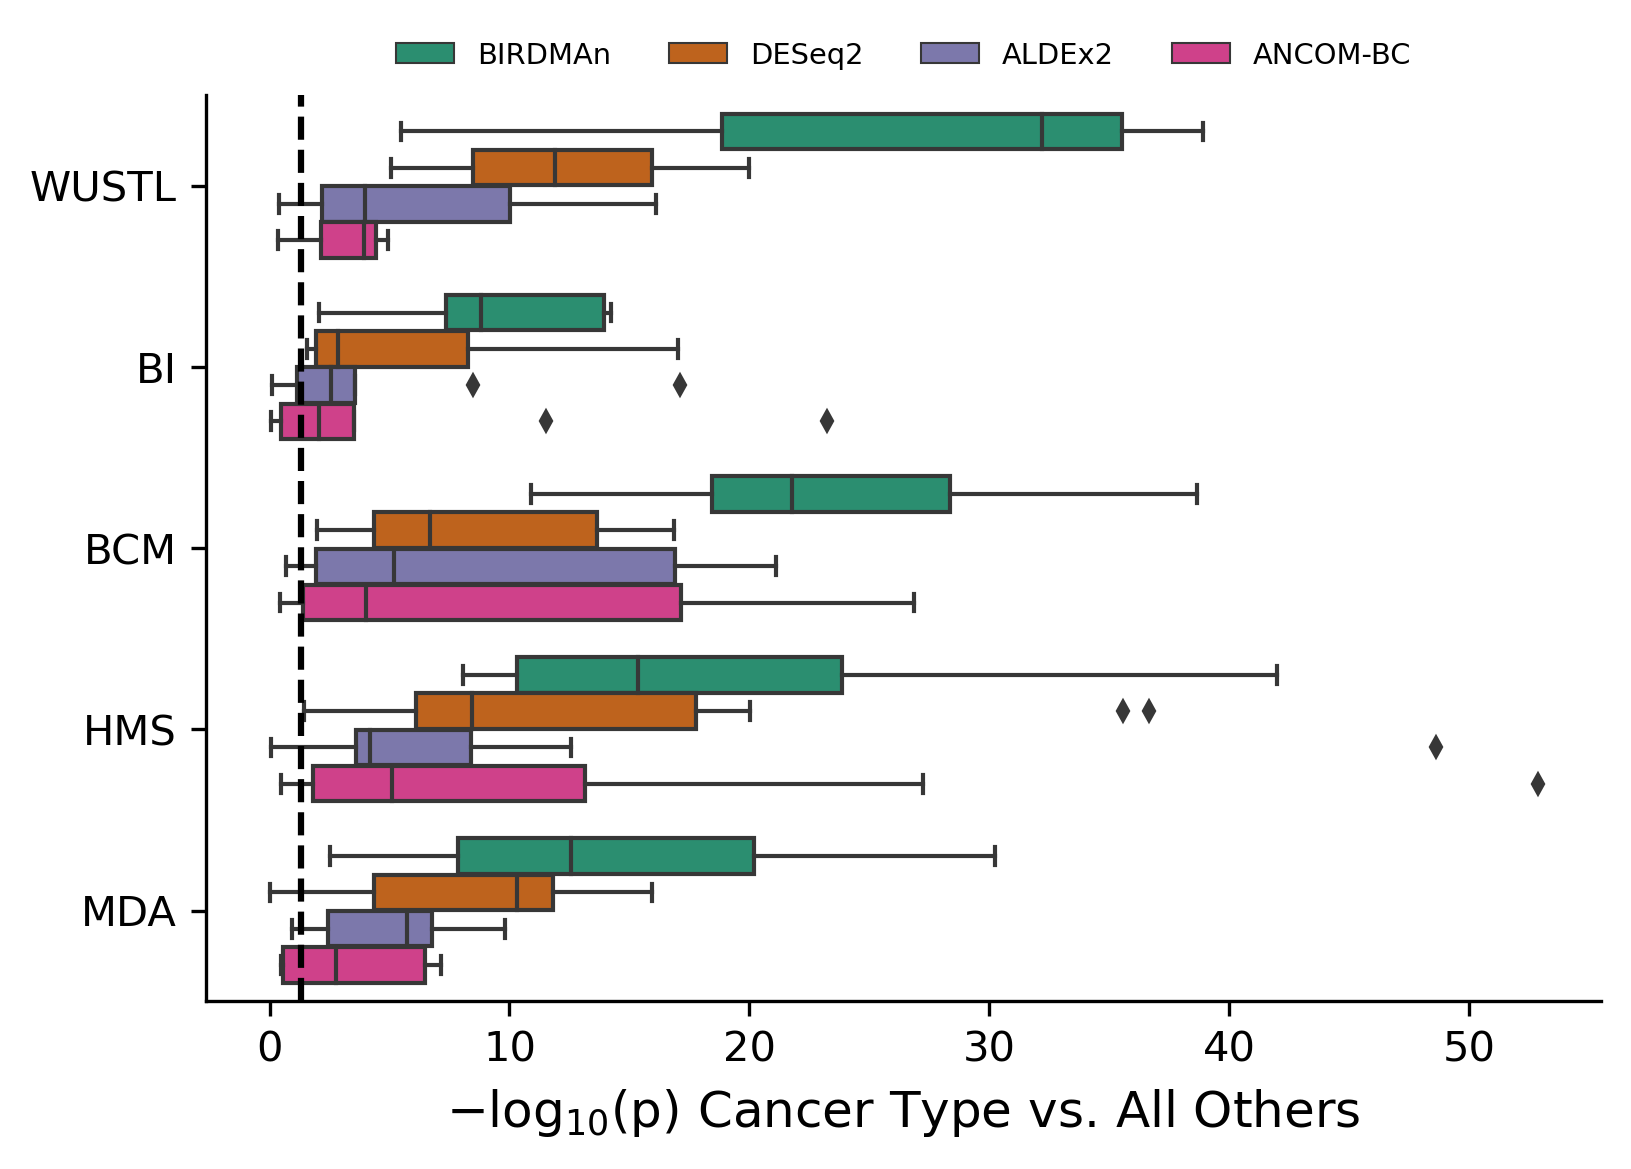

In [42]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(
    data=all_result_df,
    y="center",
    x="neg_log10_p",
    hue="tool",
    palette=tool_palette,
    linewidth=1,
    hue_order=order[:-1],
    flierprops={"markersize": 3},
    ax=ax
)
ax.axvline(-np.log10(0.05), ls="--", color="k")

ax.set_ylabel("")
ax.set_xlabel(r"$-\log_{10}\left(\mathrm{p}\right)$ Cancer Type vs. All Others")

ax.legend(
    loc="lower center",
    bbox_to_anchor=[0.5, 1],
    ncol=4,
    frameon=False,
)

plt.savefig("../figures/tcga/neg_log10_p_by_center_tool.pdf")
plt.show()

# Leave one center out

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

log_reg = LogisticRegression(
    penalty="none",
    class_weight="balanced",
    max_iter=5000
)

def leave_one_center_out(predictor_df, investigation):
    all_centers = md.query("investigation == @investigation")["data_submitting_center_label"].unique()
    
    X = predictor_df[predictor_df["data_submitting_center_label"].isin(all_centers)]
    y = (X["investigation"] == investigation).astype(int)
    X = X.drop(columns=["investigation", "data_submitting_center_label"])
    X = X.join(to_join, how="inner")
    
    perf_dict = dict()

    for group in all_centers:
        train_idx = predictor_df[
            (predictor_df["data_submitting_center_label"].isin(all_centers)) &
            (predictor_df["data_submitting_center_label"] != group)
        ].index
        test_idx = md[md["data_submitting_center_label"] == group].index

        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx]

        log_reg.fit(X_train, y_train)
        y_proba = log_reg.predict_proba(X_test)
        y_pred = log_reg.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
        
        auc_roc = roc_auc_score(y_test, y_proba[:, 1])
        auc_pr = auc(recall, precision)

        perf_dict[group] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc_roc": auc_roc,
            "precision": precision,
            "recall": recall,
            "auc_prc": auc_pr
        }
                
    return perf_dict

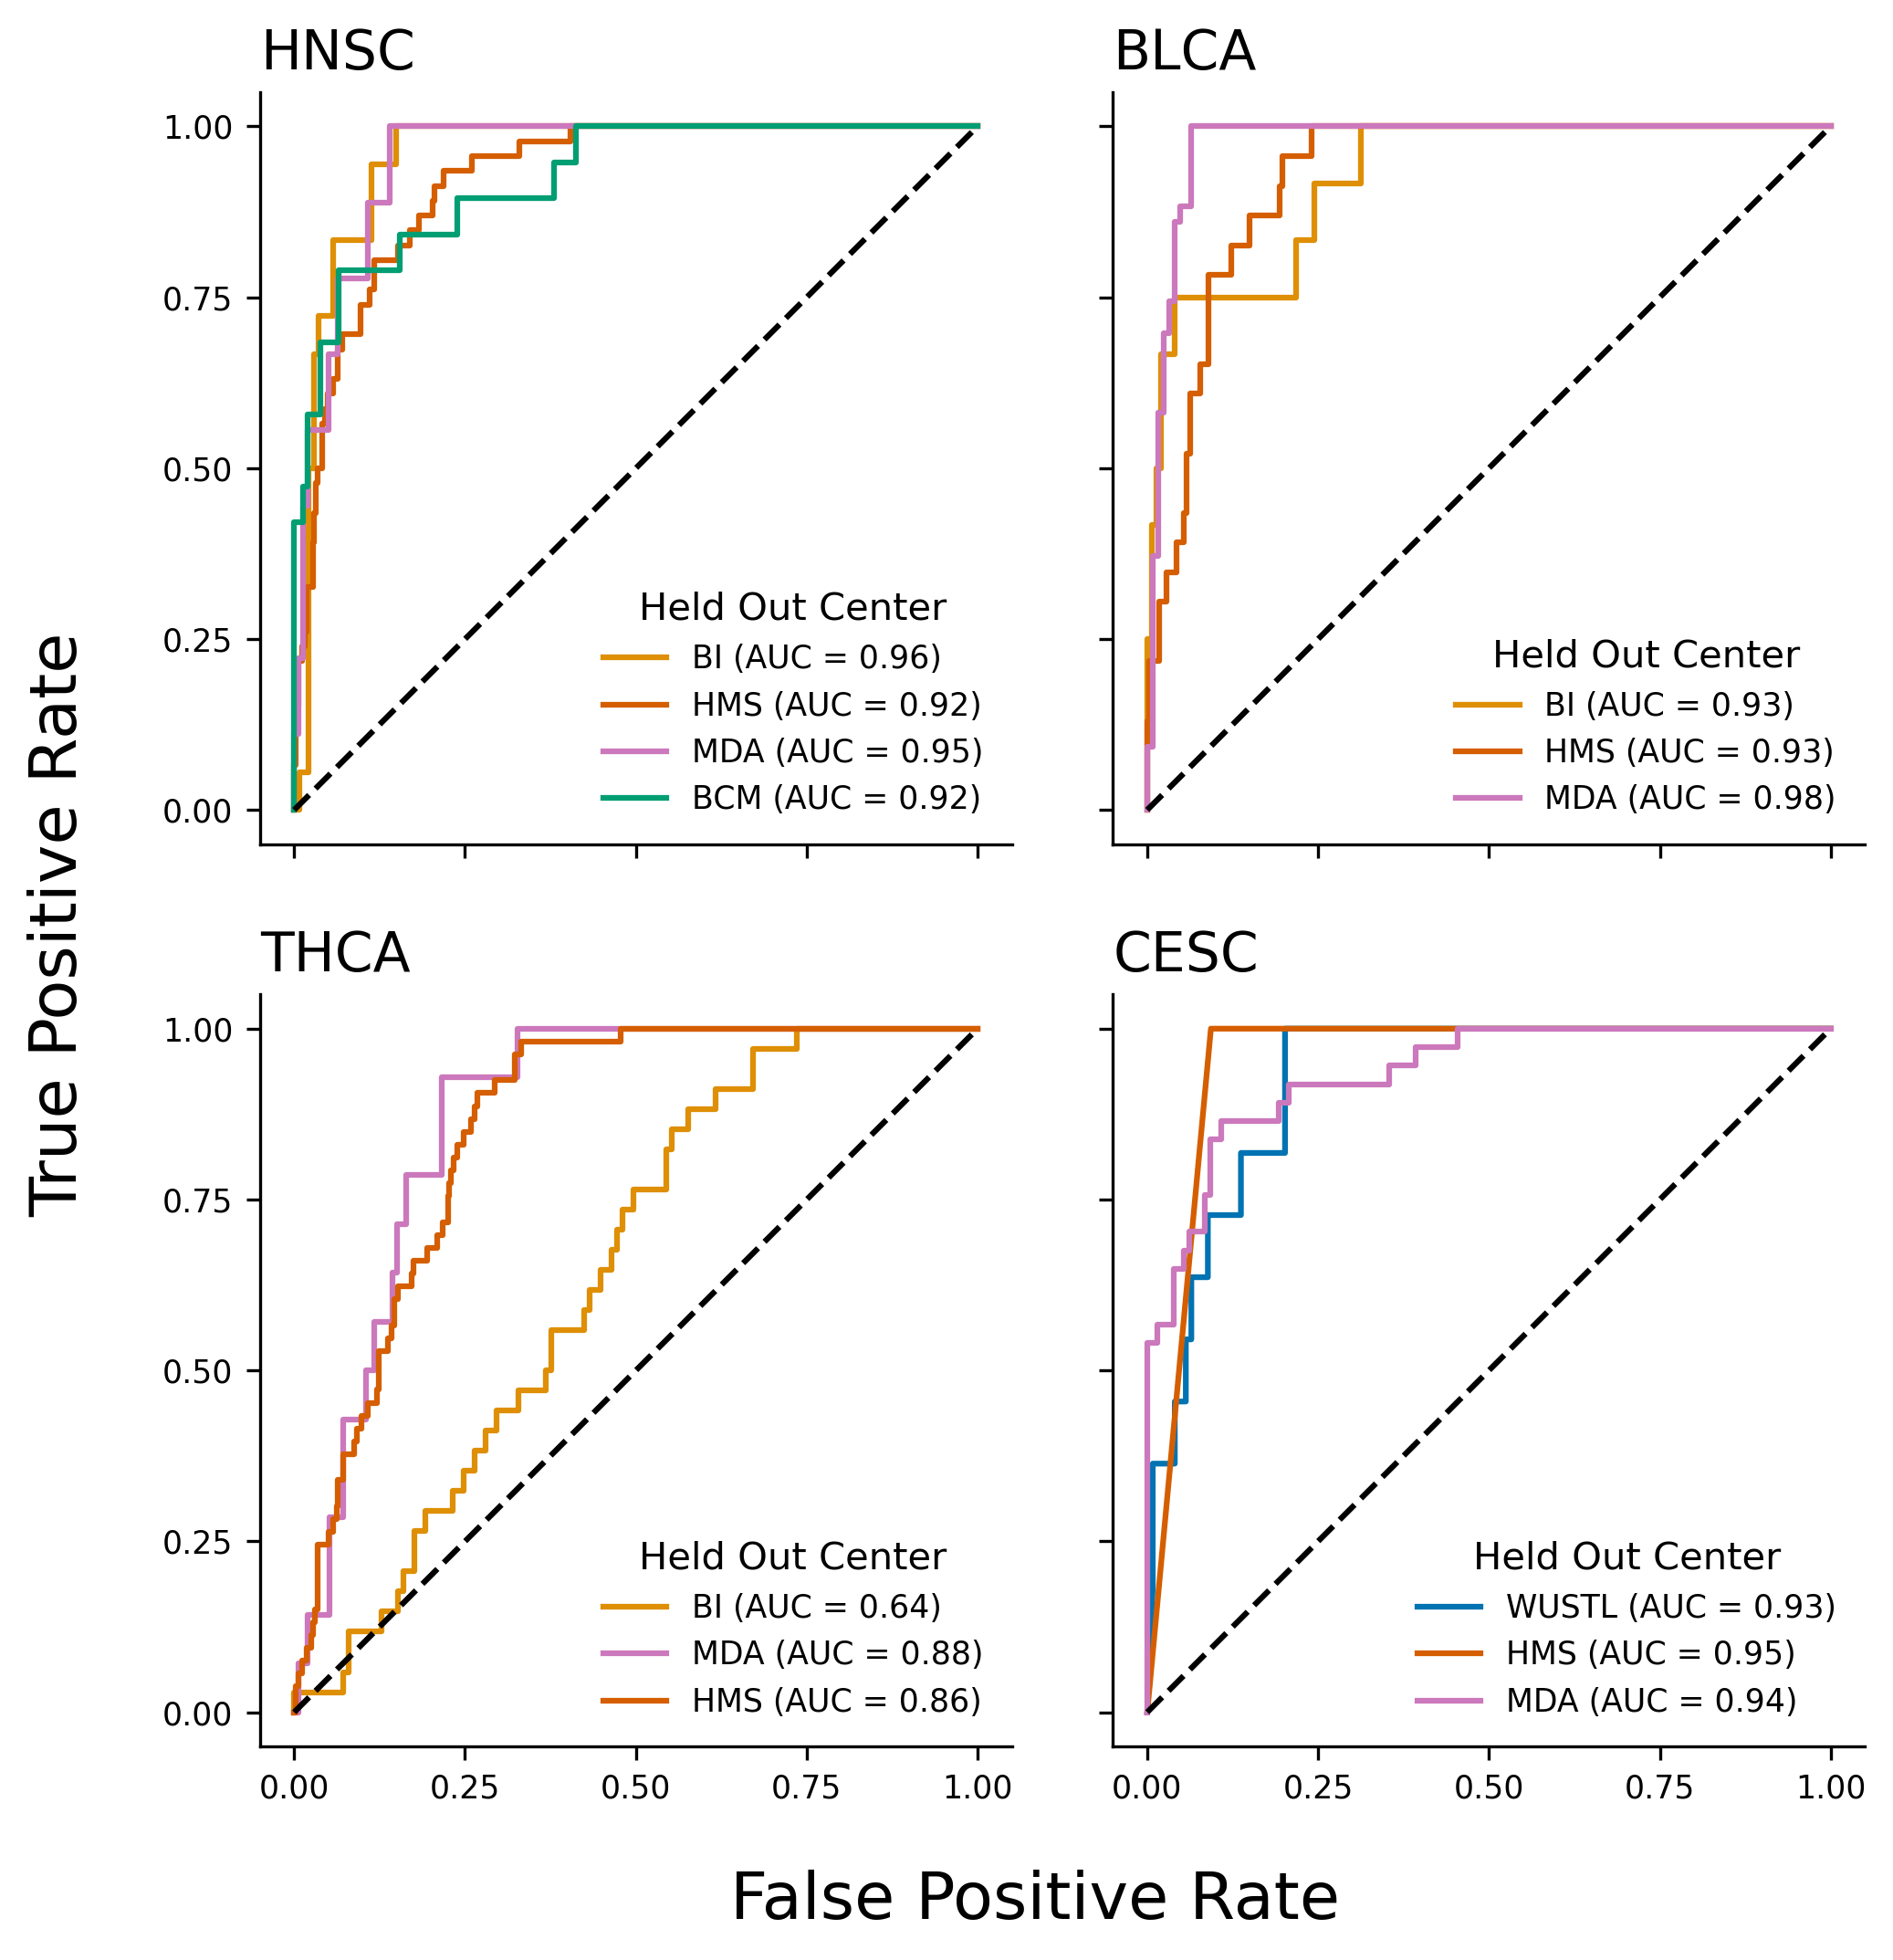

In [44]:
loo_invests = ["HNSC", "BLCA", "THCA", "CESC"]
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 8), sharex=True)
plt.subplots_adjust(wspace=0.01)

for ax, invest in zip(axs.flatten(), loo_invests):
    perf_dict = leave_one_center_out(tool_predictor_dfs["birdman"], invest)
    aucs = [v["auc_roc"] for k, v in perf_dict.items()]
    
    for group, group_dict in perf_dict.items():
        label = f"{centers_short_map[group]} (AUC = {group_dict['auc_roc']:.2f})"
        ax.plot(
            group_dict["fpr"],
            group_dict["tpr"],
            label=label,
            color=center_pal[group]
        )

    ax.legend(title="Held Out Center", frameon=False, fontsize="small")
    ax.plot([0, 1], [0, 1], ls="--", color="k")
    ax.set_aspect("equal")
    ax.set_title(invest)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    ax.tick_params("both", labelsize="small")

fig.supxlabel("False Positive Rate", y=0.04, fontsize="xx-large")
fig.supylabel("True Positive Rate", x=0.04, fontsize="xx-large")

plt.savefig("../figures/tcga/leave_one_center_out_birdman.pdf")
plt.show()